In [20]:
from bs4 import BeautifulSoup
import importlib
import csv
import random
import itertools
from mqdq import line_analyzer as la
from mqdq import utils
from mqdq import mahalanobis as maha
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from scipy.stats import chi2
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [26]:
# sklearn can be noisy.

import warnings
warnings.filterwarnings('ignore')

In [27]:
# Load R magic for Jupyter

%load_ext rpy2.ipython

In [315]:
%%R

# Setup R stuff. Not sure if I use all of this, it's my standard bundle.

pacman::p_load(
    tidyverse,forcats,
    readxl,microbenchmark,ggsci,
    gapminder,broom,purrrlyr,knitr,DT, htmlTable, grid
)

In [6]:
# Import all the MQDQ XML files
# *_soup is a BeautifulSoup object
# * is a list of XML lines in MQDQ format
# *_d is a 'distribution' - lines that have been transformed into binary feature vectors

with open('SIL-puni.xml') as fh:
    puni_soup = BeautifulSoup(fh,"xml")

puni = utils.clean(puni_soup('line'))
puni_books = [utils.clean(d('line')) for d in puni_soup('division')]    
addit=puni_books[7][143:224]
puni_na = [l for l in puni if l not in addit]

with open('VERG-aene.xml') as fh:
    aen_soup = BeautifulSoup(fh,"xml")
aen = utils.clean(aen_soup('line'))

with open('OV-meta.xml') as fh:
    met_soup = BeautifulSoup(fh,"xml")
met = utils.clean(met_soup('line'))

with open('STAT-theb.xml') as fh:
    theb_soup = BeautifulSoup(fh,"xml")
theb = utils.clean(theb_soup('line'))

with open('LVCAN-phar.xml') as fh:
    phar_soup = BeautifulSoup(fh,"xml")
phar = utils.clean(phar_soup('line'))

In [11]:
puni[0]

<line metre="H" name="1" pattern="DDSS">
<word sy="1A1b1c" wb="DI">Ordior</word>
<word sy="2A2b" wb="CF">arma,</word>
<word sy="2c3A" wb="CM">quibus</word>
<word sy="3T4A" wb="CM">caelo</word>
<word sy="4T" wb="DI">se</word>
<word sy="5A5b5c" wb="DI">gloria</word>
<word sy="6A6X">tollit</word>
</line>

In [9]:
utils.blat(puni[:5])

Ordior  arma, quibus caelo se gloria  tollit
`1A1b1c `2A2b `2c3A  `3T4A 4T `5A5b5c `6A6X

Aeneadum  patiturque ferox Oenotria  iura
1A`1b1c2A 2b2c`3A3b  `3c4A 4T`5A5b5c `6A6X

Carthago. da, Musa, decus memorare  laborum
1A`1T2A   2T  `3A3b `3c4A 4b4c`5A5b 5c`6A6X

Antiquae Hesperiae, quantosque ad bella crearit
1A`1T_   2A`2b2c3A  3T`4A_     4T `5A5b 5c`6A6X

Et quot Roma  uiros, sacri cum perfida pacti
1A 1T   `2A2b `2c3A  `3T4A 4T  `5A5b5c `6A6X


In [351]:
puni_d = la.distribution(puni_na).sample(frac=1, random_state=42)
puni_all_d = la.distribution(puni).sample(frac=1, random_state=42)
aen_d = la.distribution(aen).sample(frac=1, random_state=42)
met_d = la.distribution(met).sample(frac=1, random_state=42)
theb_d = la.distribution(theb).sample(frac=1, random_state=42)
phar_d = la.distribution(phar).sample(frac=1, random_state=42)

In [259]:
aen_d.head(5)

F1S  F2S  F3S  F4S  F1C  F2C  F3C  F4C  BD  F2SC  F3SC  F4SC  F2WC  \
6802    0    1    1    0    1    1    1    0   0     1     1     0     0   
7118    0    0    0    0    0    1    1    1   0     0     1     1     0   
106     1    1    0    0    0    1    1    1   1     1     1     1     0   
439     0    1    0    0    0    1    0    1   1     1     0     1     0   
8080    0    1    1    1    0    1    1    1   0     0     1     0     0   

      F3WC  F4WC  SYN  
6802     0     1    0  
7118     0     0    1  
106      0     0    1  
439      1     0    0  
8080     0     0    0

In [40]:
# Helper functions

In [17]:
def consolidated_data(set1, set2, auth1=0, auth2=1, chunksz=81, feats=la.ALL_FEATURES):
    
    # Consolidate data from two distributions and apply chunking.
    
    s1c = la._chunk_mean(set1, chunksz)
    s1c.insert(0, 'Author', auth1)
    s2c = la._chunk_mean(set2, chunksz)
    s2c.insert(0, 'Author', auth2)
    consol = pd.concat([s1c, s2c])
    X = consol[feats]
    y = consol['Author']
    return (X,y)

In [260]:
def test_clf_by_feats(clfs, set1, set2, feats, size=81, samps=100, confidence=0.95):
    
    # Test Classifiers by feature subsets
    
    res = []
    for (fname, f) in feats:
        for (name, c) in clfs:
            # Performs repeated testing with the given test/train split.
            # 'Stratified' means it takes roughly even number of training samples from each set
            X,y = consolidated_data(set1, set2, size, feats=f)
            cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=42)
            # Default cross validation score for 2 categories is just simple accuracy
            samp_res = cross_val_score(c(), X, y, cv=cv)
            m = sp.mean(samp_res)
            se = sp.stats.sem(samp_res)
            # student's T, 'percent point function'
            ci = se * sp.stats.t.ppf((1 + confidence) / 2, samps - 1)
            res.append({'Classifier':name, 'Features':fname, 'Score':m, 'CI': ci})
    return pd.DataFrame(res)

In [39]:
# Figure 2: Effectiveness of Different Feature Subsets

In [353]:

f = [
    ('Feet Only',['F1S', 'F2S', 'F3S', 'F4S']),
    ('Conflict Only', ['F1C', 'F2C', 'F3C', 'F4C']),
    ('Caesurae Only', ['F2SC', 'F3SC', 'F4SC', 'F2WC', 'F3WC', 'F4WC']),
    ('Feet+Conflict', ['F1S', 'F2S', 'F3S', 'F4S', 'F1C', 'F2C', 'F3C', 'F4C']),
    ('Feet+Caesurae', ['F1S', 'F2S', 'F3S', 'F4S', 'F2SC', 'F3SC', 'F4SC', 'F2WC', 'F3WC', 'F4WC']),
    ('Caes+Confl+FirstFoot', ['F1S', 'F1C', 'F2C', 'F3C', 'F4C', 'F2SC', 'F3SC', 'F4SC', 'F2WC', 'F3WC', 'F4WC']),
    ('Top 6', ['F1S','F3WC','F3C','F4SC','F2C','SYN']),
    ('All Features', ['F1S', 'F2S', 'F3S', 'F4S', 'F1C', 'F2C', 'F3C', 'F4C', 'BD', 'F2SC', 'F3SC', 'F4SC', 'F2WC', 'F3WC', 'F4WC', 'SYN']),
]
clfs = [
    ('GaussianNB', lambda: GaussianNB()),
    ('Logistic', lambda: LogisticRegression(penalty='none', solver='lbfgs')),
    ('ExtraTrees', lambda: ExtraTreesClassifier(n_estimators=100,min_samples_split=2)),
    # It is possible to obtain slightly better SVM results using an RBF kernel with
    # careful hyperparameter tuning, but it seemed like needless cherry-picking.
    ('SVM', lambda: SVC(gamma='scale', kernel='poly', shrinking=False))
]
res_feats = test_clf_by_feats(clfs, puni_all_d, aen_d, f, size=81, samps=100)
res_feats.head()

CI  Classifier       Features     Score
0  0.007250  GaussianNB      Feet Only  0.873455
1  0.007194    Logistic      Feet Only  0.873818
2  0.007122  ExtraTrees      Feet Only  0.853818
3  0.007854         SVM      Feet Only  0.858545
4  0.009868  GaussianNB  Conflict Only  0.851273

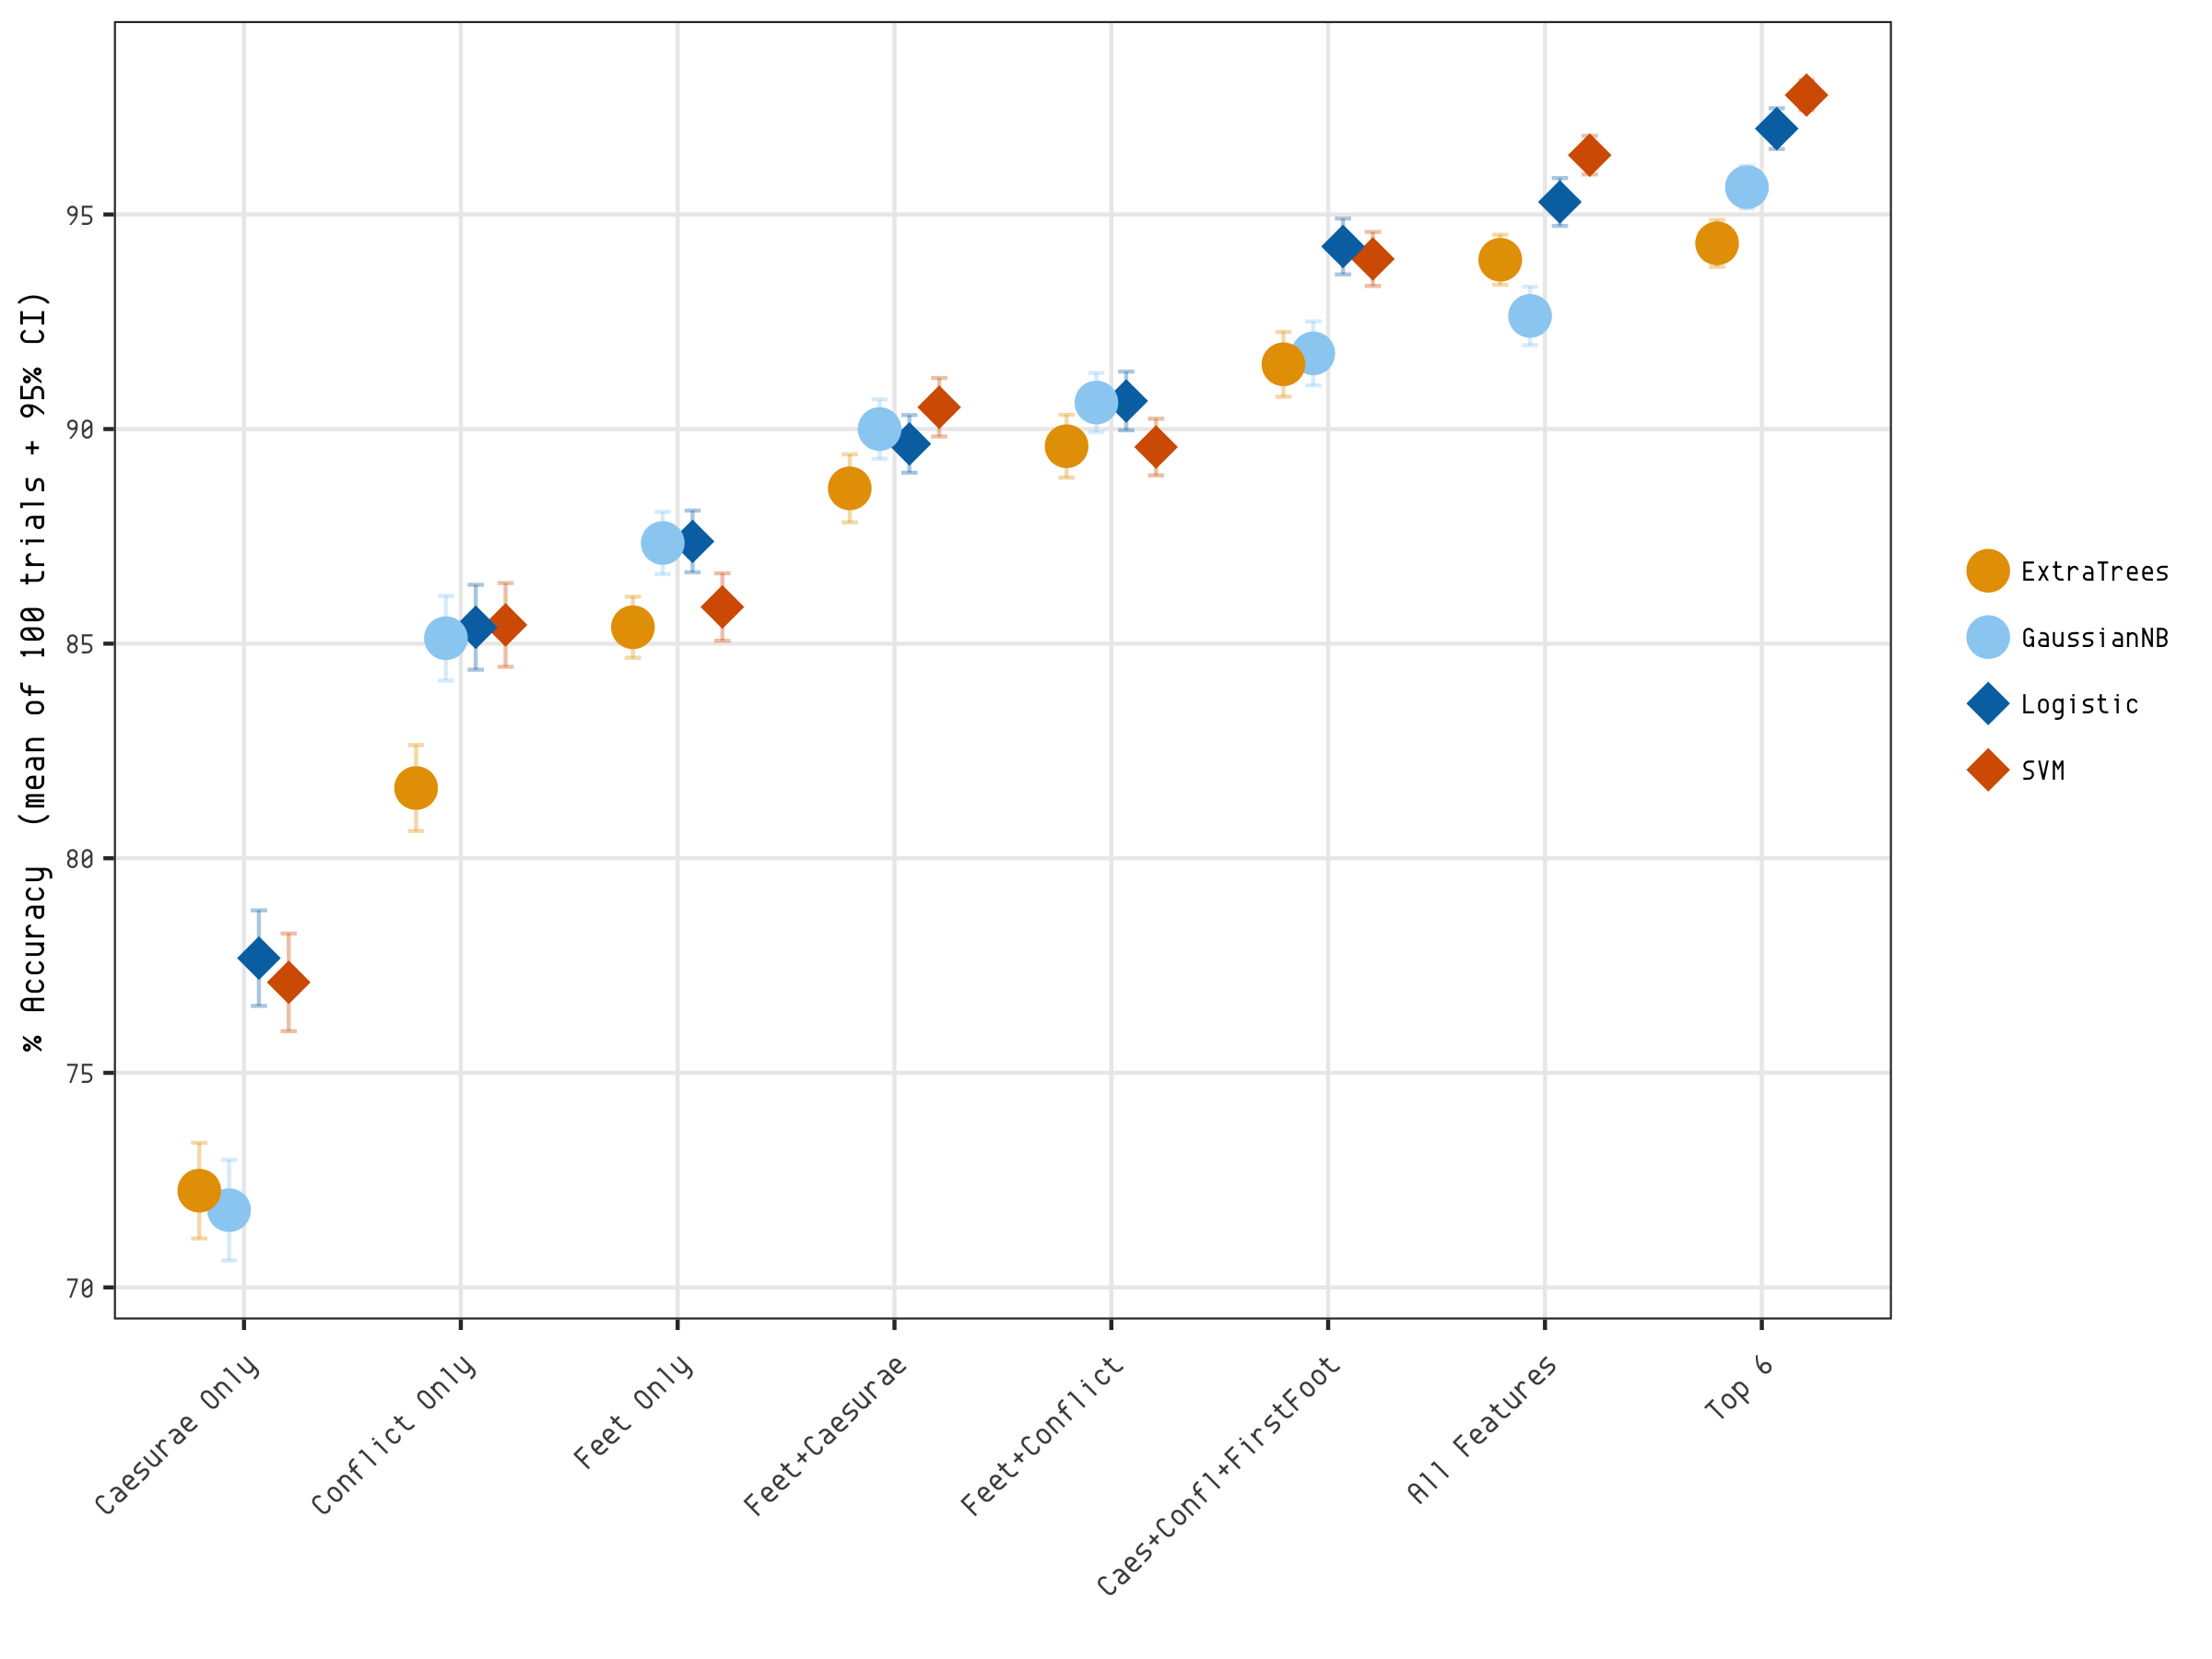

In [354]:
%%R -i res_feats -h 6 -w 8 -u in -r 300

# To _actually_ repro this might involve some fiddling around, and
# installing some fonts and such.

# a colorblind friendly palette
cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

ggplot(data=res_feats, aes(x=fct_reorder(Features, Score), y=Score*100)) +
scale_shape_manual(values=c(16,16,18,18)) +
geom_errorbar(
    aes(ymin=Score*100-CI*100, ymax=Score*100+CI*100, color=Classifier), 
    width=0.3, alpha=0.35, position=position_dodge(width = 0.55), show.legend=FALSE) +
scale_y_continuous(breaks = seq(round(min(res_feats$Score*100),digits=-1), 100, by = 5)) +
geom_point(aes(shape=Classifier, color=Classifier), size=5, alpha=1, position=position_dodge(width = 0.55)) +
labs(x="",y="% Accuracy  (mean of 100 trials + 95% CI)") +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.95, size=8)) +
scale_colour_manual(values=cbbPaletteDark[c(2:5)])

In [ ]:
# Table 1: Ranked Feature Importances

In [44]:
# Create a list of all pairwise comparisons, using the distributions we
# created earlier

data = [("Silius", puni_all_d), ("Vergil", aen_d), ("Ovid", met_d), ("Statius", theb_d), ("Lucan", phar_d)]
data_pairs = list(itertools.combinations(data, 2))

In [60]:
# This code doesn't use StratifiedShuffleSplit because the feature importances
# I need to extract are contained in weird model-specific variables. It could
# probably be cleaned up, somehow.

def et_ranked_features(set1, set2, auth1, auth2, chunksz, feats, seed=None):
    X,y = consolidated_data(set1, set2, auth1, auth2, chunksz, feats)
    Xtr, Xte, ytr, yte = train_test_split(X,y, test_size=.2, random_state=seed)
    clf = ExtraTreesClassifier(n_estimators=100,min_samples_split=2, random_state=seed)
    clf.fit(Xtr, ytr)
    pred_class = clf.predict(Xte)
    pred_actuals = pd.DataFrame([(pred, act) for pred, act in zip(pred_class, yte)], columns=['pred', 'true'])
    truth = pred_actuals.loc[:, 'true']
    pred = pred_actuals.loc[:, 'pred']
    score = accuracy_score(truth, pred)
    return (clf.feature_importances_, score)

def svm_ranked_features(set1, set2, auth1, auth2, chunksz, feats, seed=None):
    X,y = consolidated_data(set1, set2, auth1, auth2, chunksz, feats)
    Xtr, Xte, ytr, yte = train_test_split(X,y, test_size=.2, random_state=seed)
    clf = SVC(shrinking=False, class_weight='balanced', kernel='linear', C=128)
    clf.fit(Xtr, ytr)
    pred_class = clf.predict(Xte)
    pred_actuals = pd.DataFrame([(pred, act) for pred, act in zip(pred_class, yte)], columns=['pred', 'true'])
    truth = pred_actuals.loc[:, 'true']
    pred = pred_actuals.loc[:, 'pred']
    score = accuracy_score(truth, pred)
    return (np.array([abs(x) for x in clf.coef_[0]]), score)

In [50]:
# One single test, showing ranked importances for Silius vs Vergil
# The plan is to average 100 of these per pair

coef, s = svm_ranked_features(puni_d, aen_d, "Silius", "Vergil", 81, la.ALL_FEATURES)
sorted(list(zip([abs(x) for x in coef], la.ALL_FEATURES)), reverse=True)

[(23.72584448807956, 'F3WC'),
 (21.3250122644223, 'F3C'),
 (15.275167552058491, 'F1S'),
 (11.291714042425127, 'SYN'),
 (9.22966291736229, 'F2WC'),
 (8.20791631630351, 'F2C'),
 (6.295818914906704, 'F3SC'),
 (4.6718964689106315, 'F2SC'),
 (4.322991178692575, 'F3S'),
 (3.821411202364459, 'F4SC'),
 (3.0877665466938993, 'F1C'),
 (2.787821857014478, 'F4C'),
 (2.3100269297689238, 'F4S'),
 (2.115982025861399, 'BD'),
 (1.7332434127435477, 'F2S'),
 (1.3597987493211434, 'F4WC')]

In [218]:
samps=100
global_results_et = np.empty([len(data_pairs), len(la.ALL_FEATURES)])
for (idx,(a,b)) in enumerate(data_pairs):
    # This is a bit janky. Set up an empty numpy array to hold the results.
    # It has an extra column to hold the accuracy scores
    res = np.empty([samps,len(la.ALL_FEATURES)+1])
    for x in range(samps):
        f,s = et_ranked_features(a[1], b[1], a[0], b[0], 81, la.ALL_FEATURES, seed=x)
        res[x]=np.append(f*100,s)
    m = res.mean(axis=0, keepdims=True)[0]
    # slight weighting - multiply everything by accuracy, which is in [0,1]
    feats = m[:-1]*m[-1]
    # Each pair gets 100 samples, there are 10 pairs. Accuracy per pair is gone now.
    # (it was just used for the weighting)
    global_results_et[idx]=feats

# Average over all 10 pairs
gmean_et = global_results_et.mean(axis=0, keepdims=True)[0]
ordered_et = sorted(list(zip(gmean_et,la.ALL_FEATURES)), reverse=True)
ordered_et

[(23.869253475891487, 'SYN'),
 (17.974760420296473, 'F1S'),
 (9.445459374570577, 'F4S'),
 (7.092928642132551, 'F3WC'),
 (6.146523035217681, 'F1C'),
 (5.080371859936226, 'F3SC'),
 (4.990641736755933, 'F3C'),
 (3.9639669900507073, 'F3S'),
 (3.628854577460013, 'F2C'),
 (3.5791979416151944, 'F4C'),
 (2.991154699631932, 'F4SC'),
 (2.6169045961639754, 'F2WC'),
 (2.118577778738451, 'BD'),
 (1.894684094482746, 'F2S'),
 (1.7902057368637092, 'F4WC'),
 (1.6882900693959582, 'F2SC')]

In [219]:
[t[1] for t in ordered_et]

['SYN',
 'F1S',
 'F4S',
 'F3WC',
 'F1C',
 'F3SC',
 'F3C',
 'F3S',
 'F2C',
 'F4C',
 'F4SC',
 'F2WC',
 'BD',
 'F2S',
 'F4WC',
 'F2SC']

In [62]:
samps=100
global_results_svc = np.empty([len(data_pairs), len(la.ALL_FEATURES)])
for (idx,(a,b)) in enumerate(data_pairs):
    res = np.empty([samps,len(la.ALL_FEATURES)+1])
    for x in range(samps):
        f,s = svm_ranked_features(a[1], b[1], a[0], b[0], 81, la.ALL_FEATURES, seed=x)
        #print(f*100)
        res[x]=np.append(f,s)
    m = res.mean(axis=0, keepdims=True)[0]
    # slight weighting - multiply everything by accuracy, which is in [0,1]
    feats = m[:-1]*m[-1]
    global_results_svc[idx]=feats

gmean_svc = global_results_svc.mean(axis=0, keepdims=True)[0]
ordered_svc = sorted(list(zip(gmean_svc,la.ALL_FEATURES)), reverse=True)

In [124]:
[t[1] for t in ordered_svc]

['F1S',
 'SYN',
 'F3WC',
 'F4S',
 'F4SC',
 'F3C',
 'F3SC',
 'F2C',
 'F3S',
 'F4C',
 'F2S',
 'BD',
 'F2WC',
 'F4WC',
 'F1C',
 'F2SC']

In [61]:
# And so, this is the guts of Table 1.
# Everyone loves procedurally generated LaTeX, right??

a = sorted(list(zip(pd.DataFrame(global_results_et).mean(), la.ALL_FEATURES)), reverse=True)
b = sorted(list(zip(pd.DataFrame(global_results_svc).mean(), la.ALL_FEATURES)), reverse=True)
z = list(zip(a,b))
for a,b in z:
    print("\\texttt{%s} & %.2f & \\texttt{%s} & %.2f\\\\" % (a[1], a[0], b[1], b[0]))

\texttt{SYN} & 23.97 & \texttt{F1S} & 8.36\\
\texttt{F1S} & 18.02 & \texttt{SYN} & 7.67\\
\texttt{F4S} & 9.55 & \texttt{F3WC} & 5.29\\
\texttt{F3WC} & 7.14 & \texttt{F4S} & 4.25\\
\texttt{F1C} & 6.07 & \texttt{F4SC} & 3.99\\
\texttt{F3SC} & 5.07 & \texttt{F3C} & 3.92\\
\texttt{F3C} & 4.94 & \texttt{F3SC} & 2.79\\
\texttt{F3S} & 3.96 & \texttt{F2C} & 2.61\\
\texttt{F2C} & 3.58 & \texttt{F3S} & 2.54\\
\texttt{F4C} & 3.56 & \texttt{F4C} & 2.20\\
\texttt{F4SC} & 2.97 & \texttt{F2S} & 2.13\\
\texttt{F2WC} & 2.65 & \texttt{BD} & 2.08\\
\texttt{BD} & 2.11 & \texttt{F2WC} & 2.04\\
\texttt{F2S} & 1.87 & \texttt{F4WC} & 1.87\\
\texttt{F4WC} & 1.81 & \texttt{F1C} & 1.82\\
\texttt{F2SC} & 1.70 & \texttt{F2SC} & 1.72\\


In [64]:
# Figure 3: Classification Accuracy by Chunk Size: Silius vs Ovid

In [65]:
# Helper function. Fairly similar to Fig. 1.

def test_clf_by_chunksz(clfs, set1, set2, sizes, samps=100):
    res = []
    for (name, c) in clfs:
        for (idx,sz) in enumerate(sizes):
            if sz==0:
                sz=1
            X,y = consolidated_data(set1, set2, chunksz=sz)
            cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=42)
            samp_res = cross_val_score(c(), X, y, cv=cv)
            m = sp.mean(samp_res)
            res.append({'Classifier':name, 'Score':m, 'Size': sz})
    return pd.DataFrame(res)

In [66]:
r = range(5,151,5)
clfs = [
    ('GaussianNB', lambda: GaussianNB()),
    ('Logistic', lambda: LogisticRegression(penalty='none', solver='lbfgs')),
    ('ExtraTrees', lambda: ExtraTreesClassifier(n_estimators=100,min_samples_split=2)),
    ('SVM', lambda: SVC(gamma='scale', kernel='poly', shrinking=False))
]
chunks_ov_sil = test_clf_by_chunksz(clfs, puni_all_d, met_d, r, samps=100)

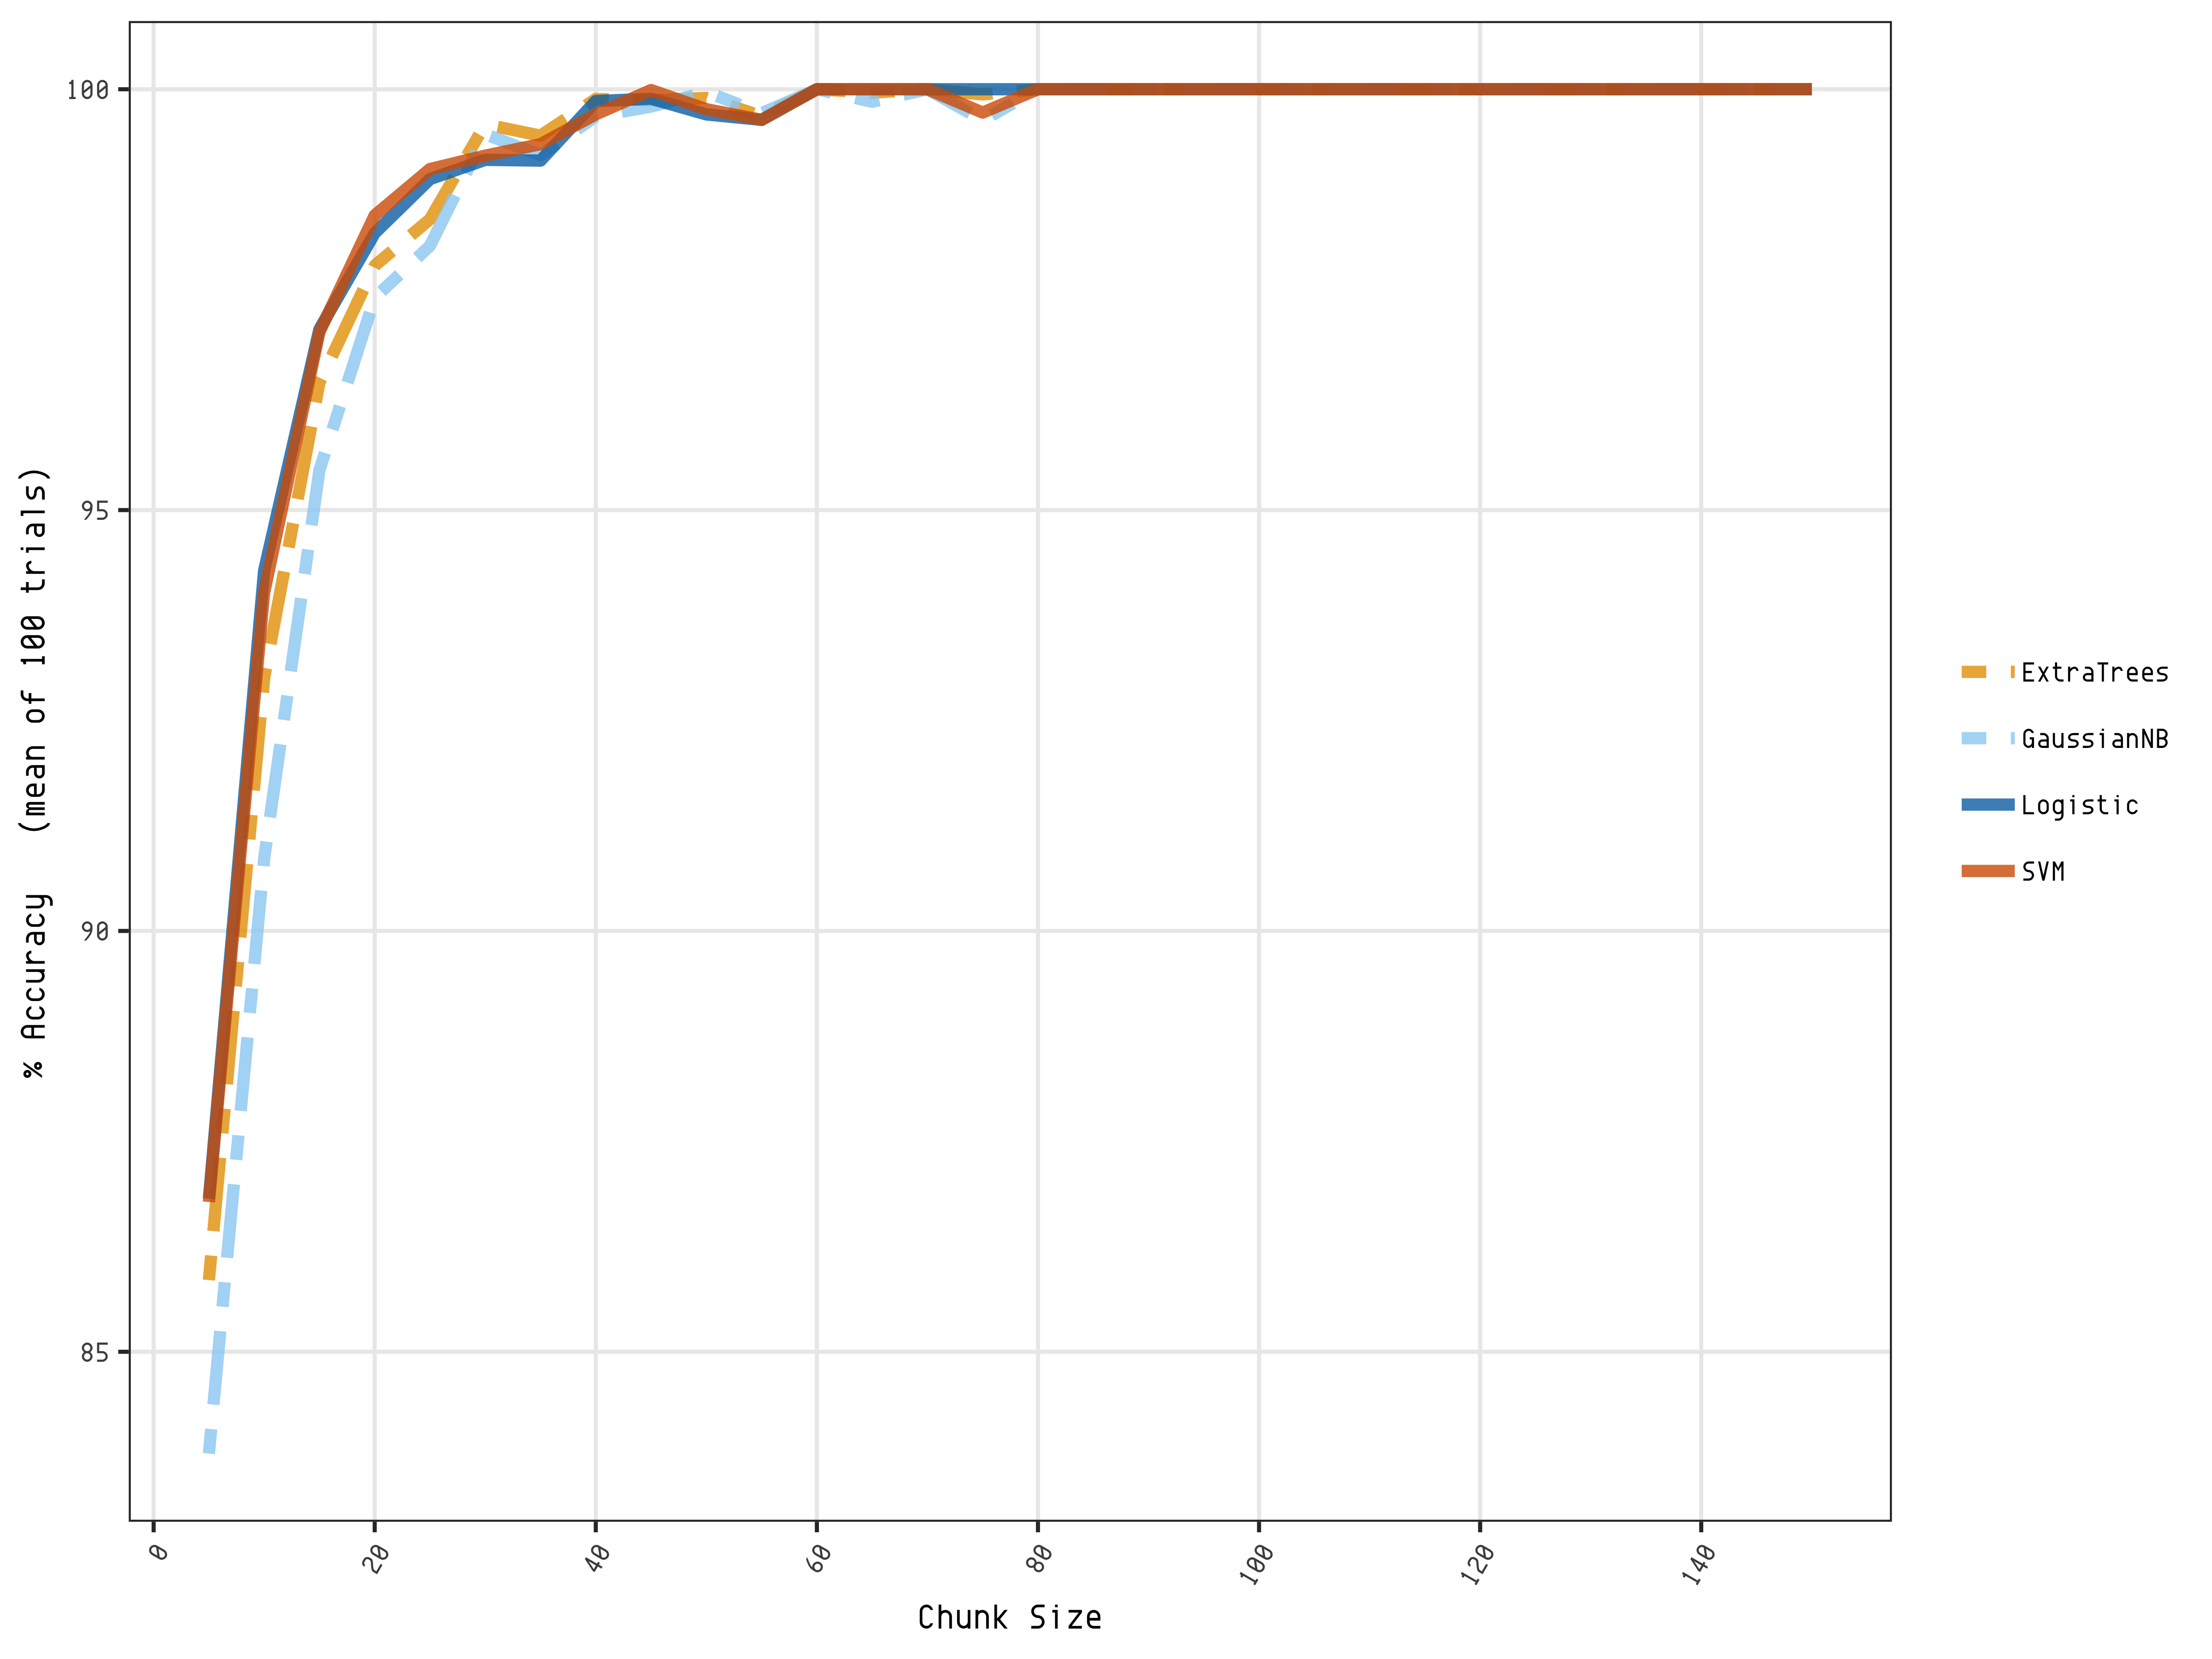

In [67]:
%%R -i chunks_ov_sil -h 6 -w 8 -u in -r 600


cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
ggplot(data=chunks_ov_sil, aes(x=Size, y=Score*100, linetype=Classifier)) + 
geom_line(aes(color=Classifier), alpha=0.8, size=1.5) +
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
scale_colour_manual(values=cbbPaletteDark[c(2:5)]) +
labs(x="Chunk Size", y="% Accuracy   (mean of 100 trials)") +
scale_x_continuous(breaks = seq(0,150,20)) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1))

In [68]:
# Figure 4: Classification Accuracy by Chunk Size: Silius vs Vergil

In [86]:
r = range(5,151,5)
clfs = [
    ('GaussianNB', lambda: GaussianNB()),
    ('Logistic', lambda: LogisticRegression(penalty='none', solver='lbfgs')),
    ('ExtraTrees', lambda: ExtraTreesClassifier(n_estimators=100,min_samples_split=2)),
    # I tweaked the parameters here a bit :) The performance is randomly ~2% worse when
    # using a chunksize of 80 vs 81 (I have no idea why) so I used tuned hyperparameters
    # to compensate. The graph would look even better if I moved the chunk sizes by 1,
    # but I thought it would be terrible to use different tick marks from Fig. 3
    ('SVM', lambda: SVC(gamma='scale', kernel='rbf', C=256))
]
chunks_sil_ver = test_clf_by_chunksz(clfs, puni_all_d, aen_d, r, samps=100)

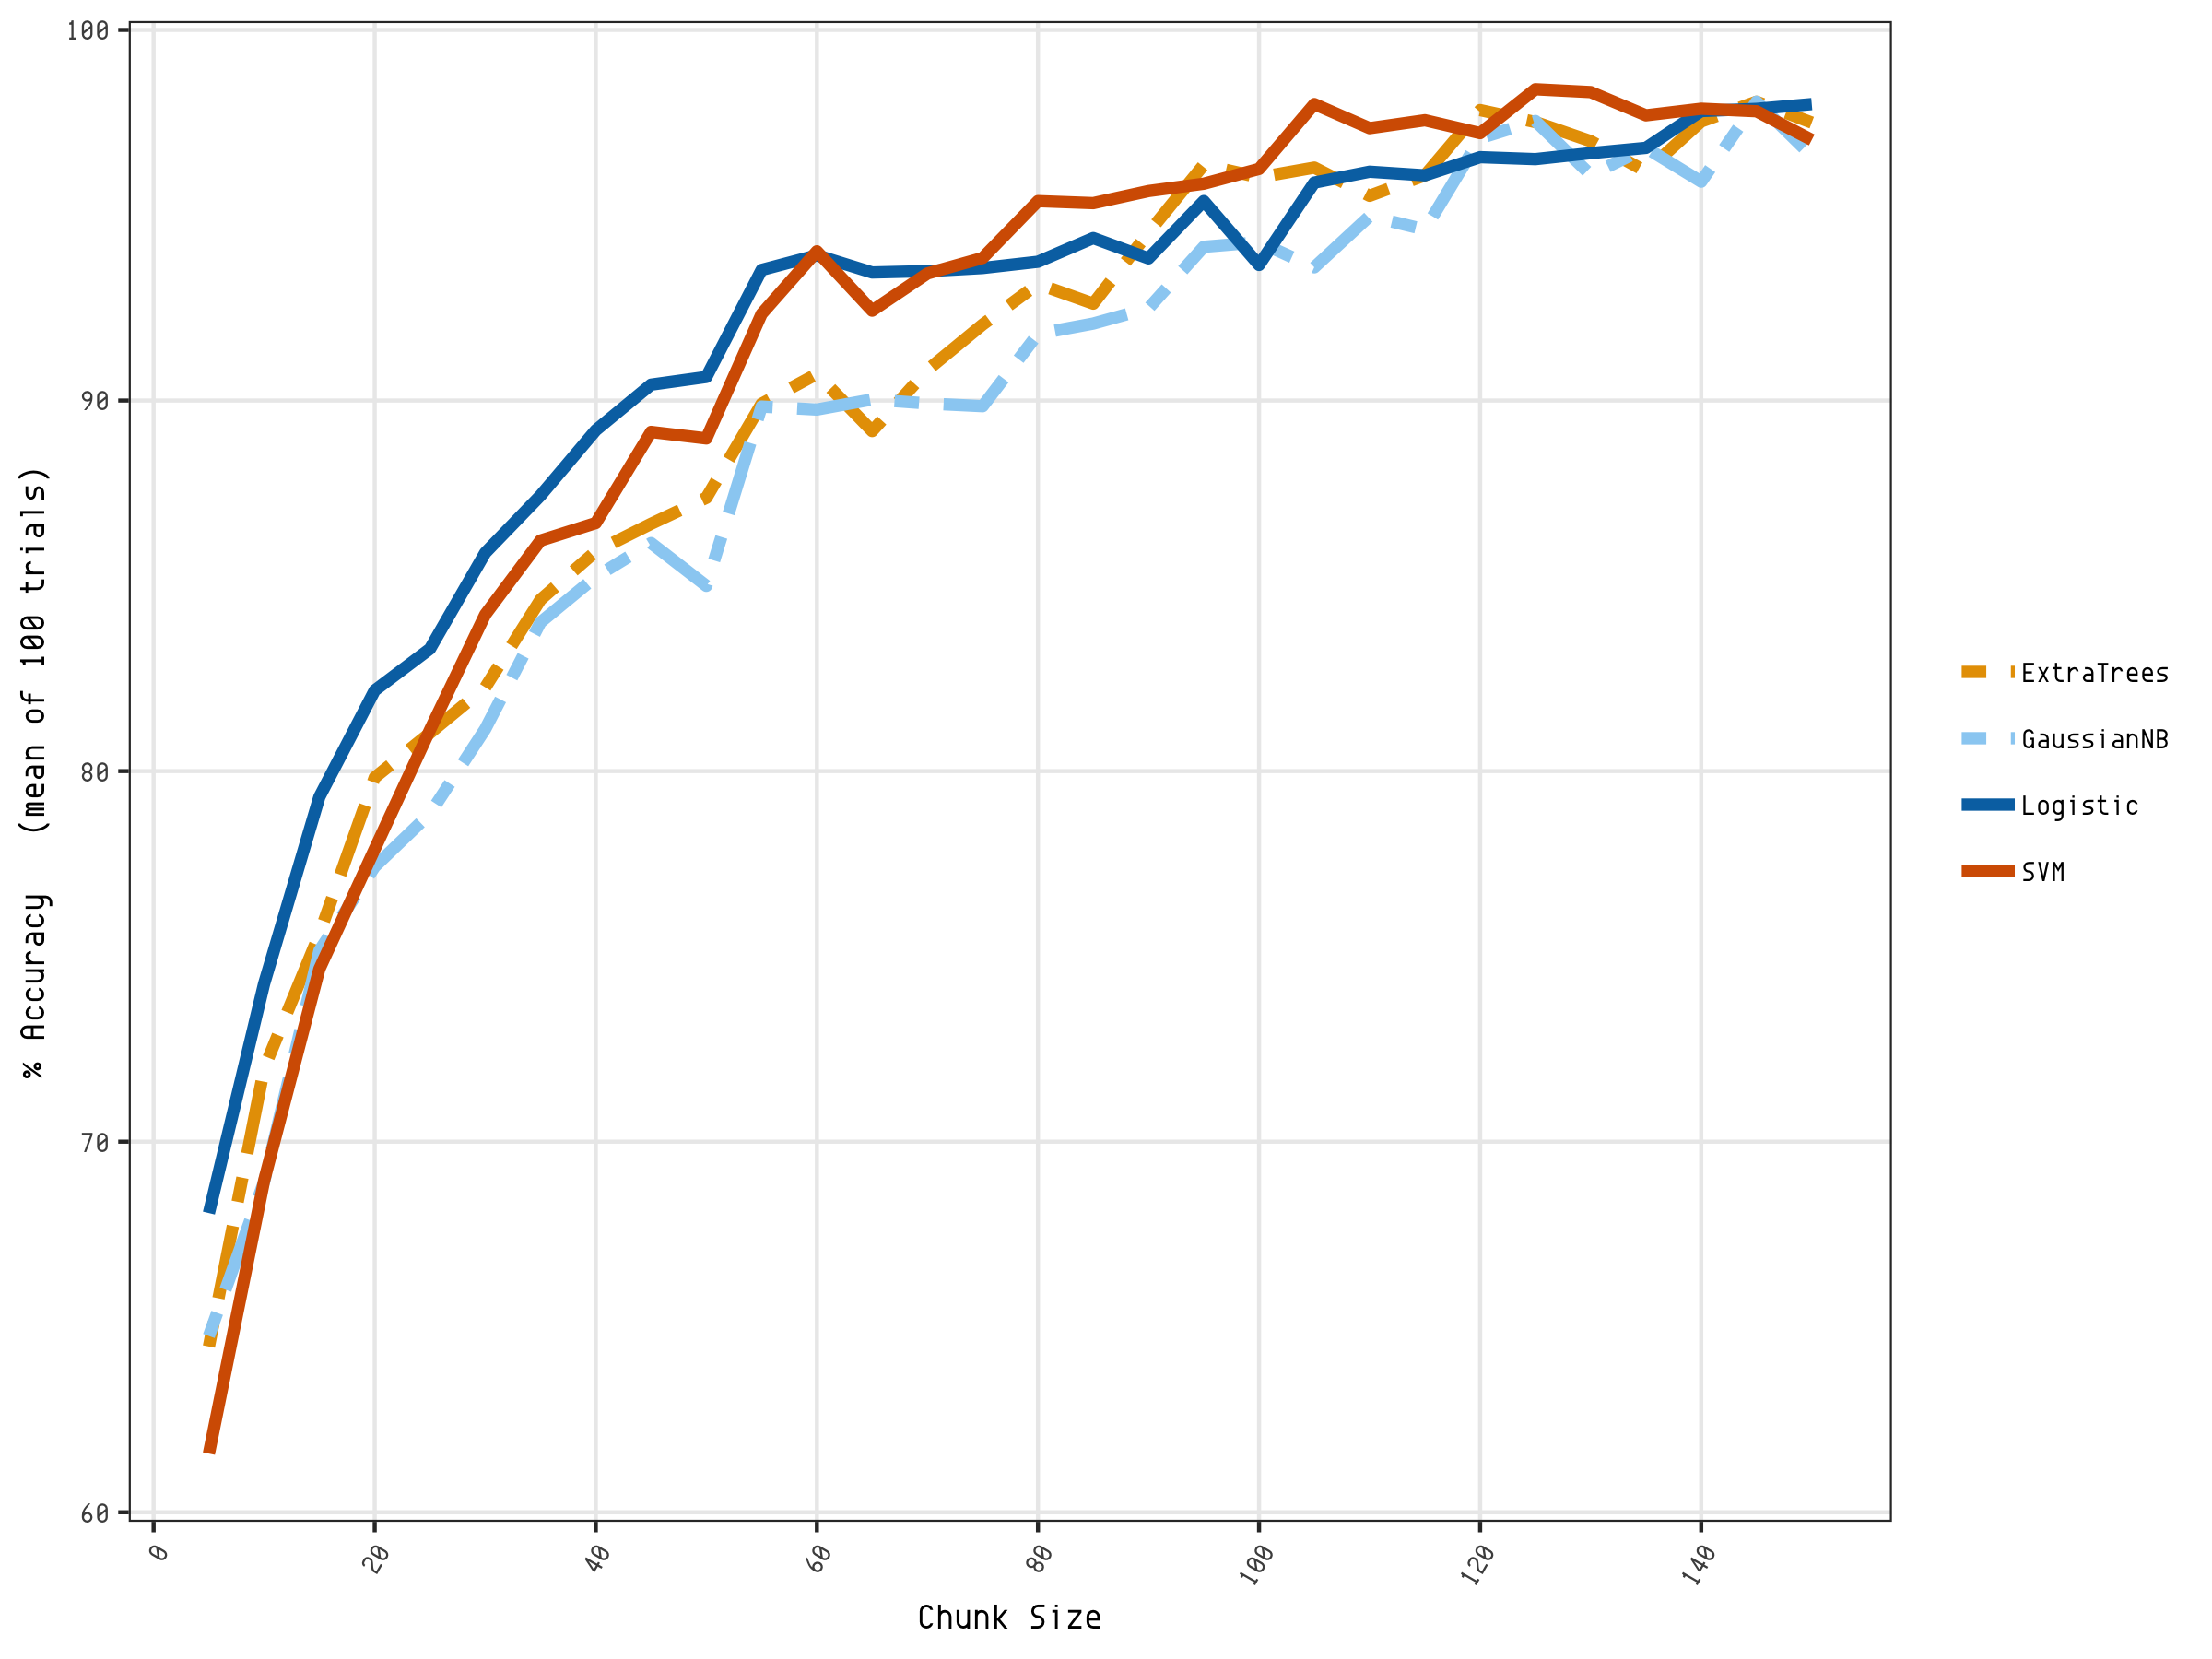

In [87]:
%%R -i chunks_sil_ver -h 6 -w 8 -u in -r 300

cbbPalette <- c("#000000", "#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))
ggplot(data=chunks_sil_ver, aes(x=Size, y=Score*100, linetype=Classifier)) + 
geom_line(aes(color=Classifier), alpha=1, size=1.5) +
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
labs(x="Chunk Size", y="% Accuracy   (mean of 100 trials)") +
scale_x_continuous(breaks = seq(0,150,20)) +
scale_color_manual(values=cbbPalette[c(3:6)]) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1))

In [77]:
# I feel like I should support my claim about the 80 vs 81 chunk sizes... ;)

for s in [80,81]:
    clf = SVC(gamma='scale', kernel='rbf', C=256)
    cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
    X,y = consolidated_data(puni_all_d, aen_d, chunksz=s, feats=la.ALL_FEATURES)
    samp_res = cross_val_score(clf, X, y, cv=cv)
    m = sp.mean(samp_res)
    se = sp.stats.sem(samp_res)
    ci = se * sp.stats.t.ppf((1 + 0.95) / 2, 100-1)

    print("Chunk Size: %d Mean Accuracy: %.3f%% ± %.3f" % (s, m*100, ci*100))

Chunk Size: 80 Mean Accuracy: 95.382% ± 0.501
Chunk Size: 81 Mean Accuracy: 96.855% ± 0.429


In [ ]:
# Figure 5: Parsimonius Models

In [100]:
# Now we want to take the 'best N features'
# There's a discussion to be had, here... I would be cautious about using the
# results from the selected features as 'accuracy' results because we're essentially
# overfitting. It's interesting data, especially for thinking more broadly about
# classification, but it would be (imho) a mistake to then use one of the reduced
# feature sets for authorship attribution when the alternative candidate is unknown.
# (You might be ignoring the key indicator features for the unknown author.)
# However, if you had a two-label attribution problem then this sort of approach is
# probably fine.

# So, here I will compare the accuracy of Silius vs Vergil with 81 line chunks, using
# the best N global features from Table 1 (I'm using the SVM list, not the ET list,
# because SVM has the best overall performance.)

# We already did all 10 pairs, and Silius vs Vergil (the one we'll graph) is the first

(data_pairs[0][0][0],data_pairs[0][1][0])

('Silius', 'Vergil')

In [102]:
# Take the first entry from the global_results_svc (before global averaging) and sort them
# As we can see, most of the 'value' has been extracted by feature 6 (SYN), so that's the
# model one would probably select.

feat_sort = sorted(list(zip(global_results_svc[0], la.ALL_FEATURES)), key=lambda t: t[0], reverse=True)
feat_sort

[(18.896247900250433, 'F1S'),
 (18.730310276635493, 'F3WC'),
 (18.689055100396946, 'F3C'),
 (15.627461135303072, 'F4SC'),
 (12.58181348714922, 'F2C'),
 (11.916065145967476, 'SYN'),
 (4.995948850016836, 'F2S'),
 (3.486185222988549, 'F3SC'),
 (2.7024701470931123, 'F4WC'),
 (2.64221680898548, 'BD'),
 (2.4780905138989175, 'F2WC'),
 (2.145358525372717, 'F4C'),
 (2.0109097590442033, 'F1C'),
 (1.4985760377330979, 'F4S'),
 (1.280163004903387, 'F2SC'),
 (1.1888459222572962, 'F3S')]

In [228]:
# These are the ordered features, according to SVM, for Silius vs Vergil

ordered_fs_local = [t[1] for t in feat_sort]
ordered_fs_local


['F1S',
 'F3WC',
 'F3C',
 'F4SC',
 'F2C',
 'SYN',
 'F2S',
 'F3SC',
 'F4WC',
 'BD',
 'F2WC',
 'F4C',
 'F1C',
 'F4S',
 'F2SC',
 'F3S']

In [241]:
# These are the ordered features based on Table 1 (for SVM), using all 10 pairwise comparisons
# and (slightly) weighted for accuracy. If this kind of reduction is something important for a 
# given project (it's not, for this paper, it's just interesting) there are probably better methods.

# Here, it's much harder to say which features to use, the taper is much more gradual, which makes
# sense given that it's averaged over several authors. From the graph (below), the magic number is 8.

ordered_fs_glob = [t[1] for t in ordered_svc]
ordered_svc

[(8.355631696071246, 'F1S'),
 (7.66564725931936, 'SYN'),
 (5.2947360587022905, 'F3WC'),
 (4.253231086242, 'F4S'),
 (3.992037435889288, 'F4SC'),
 (3.9176236497348285, 'F3C'),
 (2.7899232389312654, 'F3SC'),
 (2.613646735372148, 'F2C'),
 (2.5360733996048674, 'F3S'),
 (2.1984434663659536, 'F4C'),
 (2.13359590556771, 'F2S'),
 (2.079303779231091, 'BD'),
 (2.0384042769735524, 'F2WC'),
 (1.868884908811993, 'F4WC'),
 (1.823858739488569, 'F1C'),
 (1.7186524022870053, 'F2SC')]

In [268]:
ordered_fs_glob

['F1S',
 'SYN',
 'F3WC',
 'F4S',
 'F4SC',
 'F3C',
 'F3SC',
 'F2C',
 'F3S',
 'F4C',
 'F2S',
 'BD',
 'F2WC',
 'F4WC',
 'F1C',
 'F2SC']

In [233]:
f_local = [(x, ordered_fs_local[:x]) for x in range(1,17)]
f_global = [(x, ordered_fs_glob[:x]) for x in range(1,17)]

In [269]:
# Test the performance of the first n global features in Silius vs Vergil

clfs = [
    ('GaussianNB', lambda: GaussianNB()),
    ('Logistic', lambda: LogisticRegression(penalty='none', solver='lbfgs')),
    ('ExtraTrees', lambda: ExtraTreesClassifier(n_estimators=100,min_samples_split=2)),
    ('SVM', lambda: SVC(gamma='scale', kernel='poly'))
]
x_global = test_clf_by_feats(clfs, puni_all_d, aen_d, f_global, size=81, samps=100)

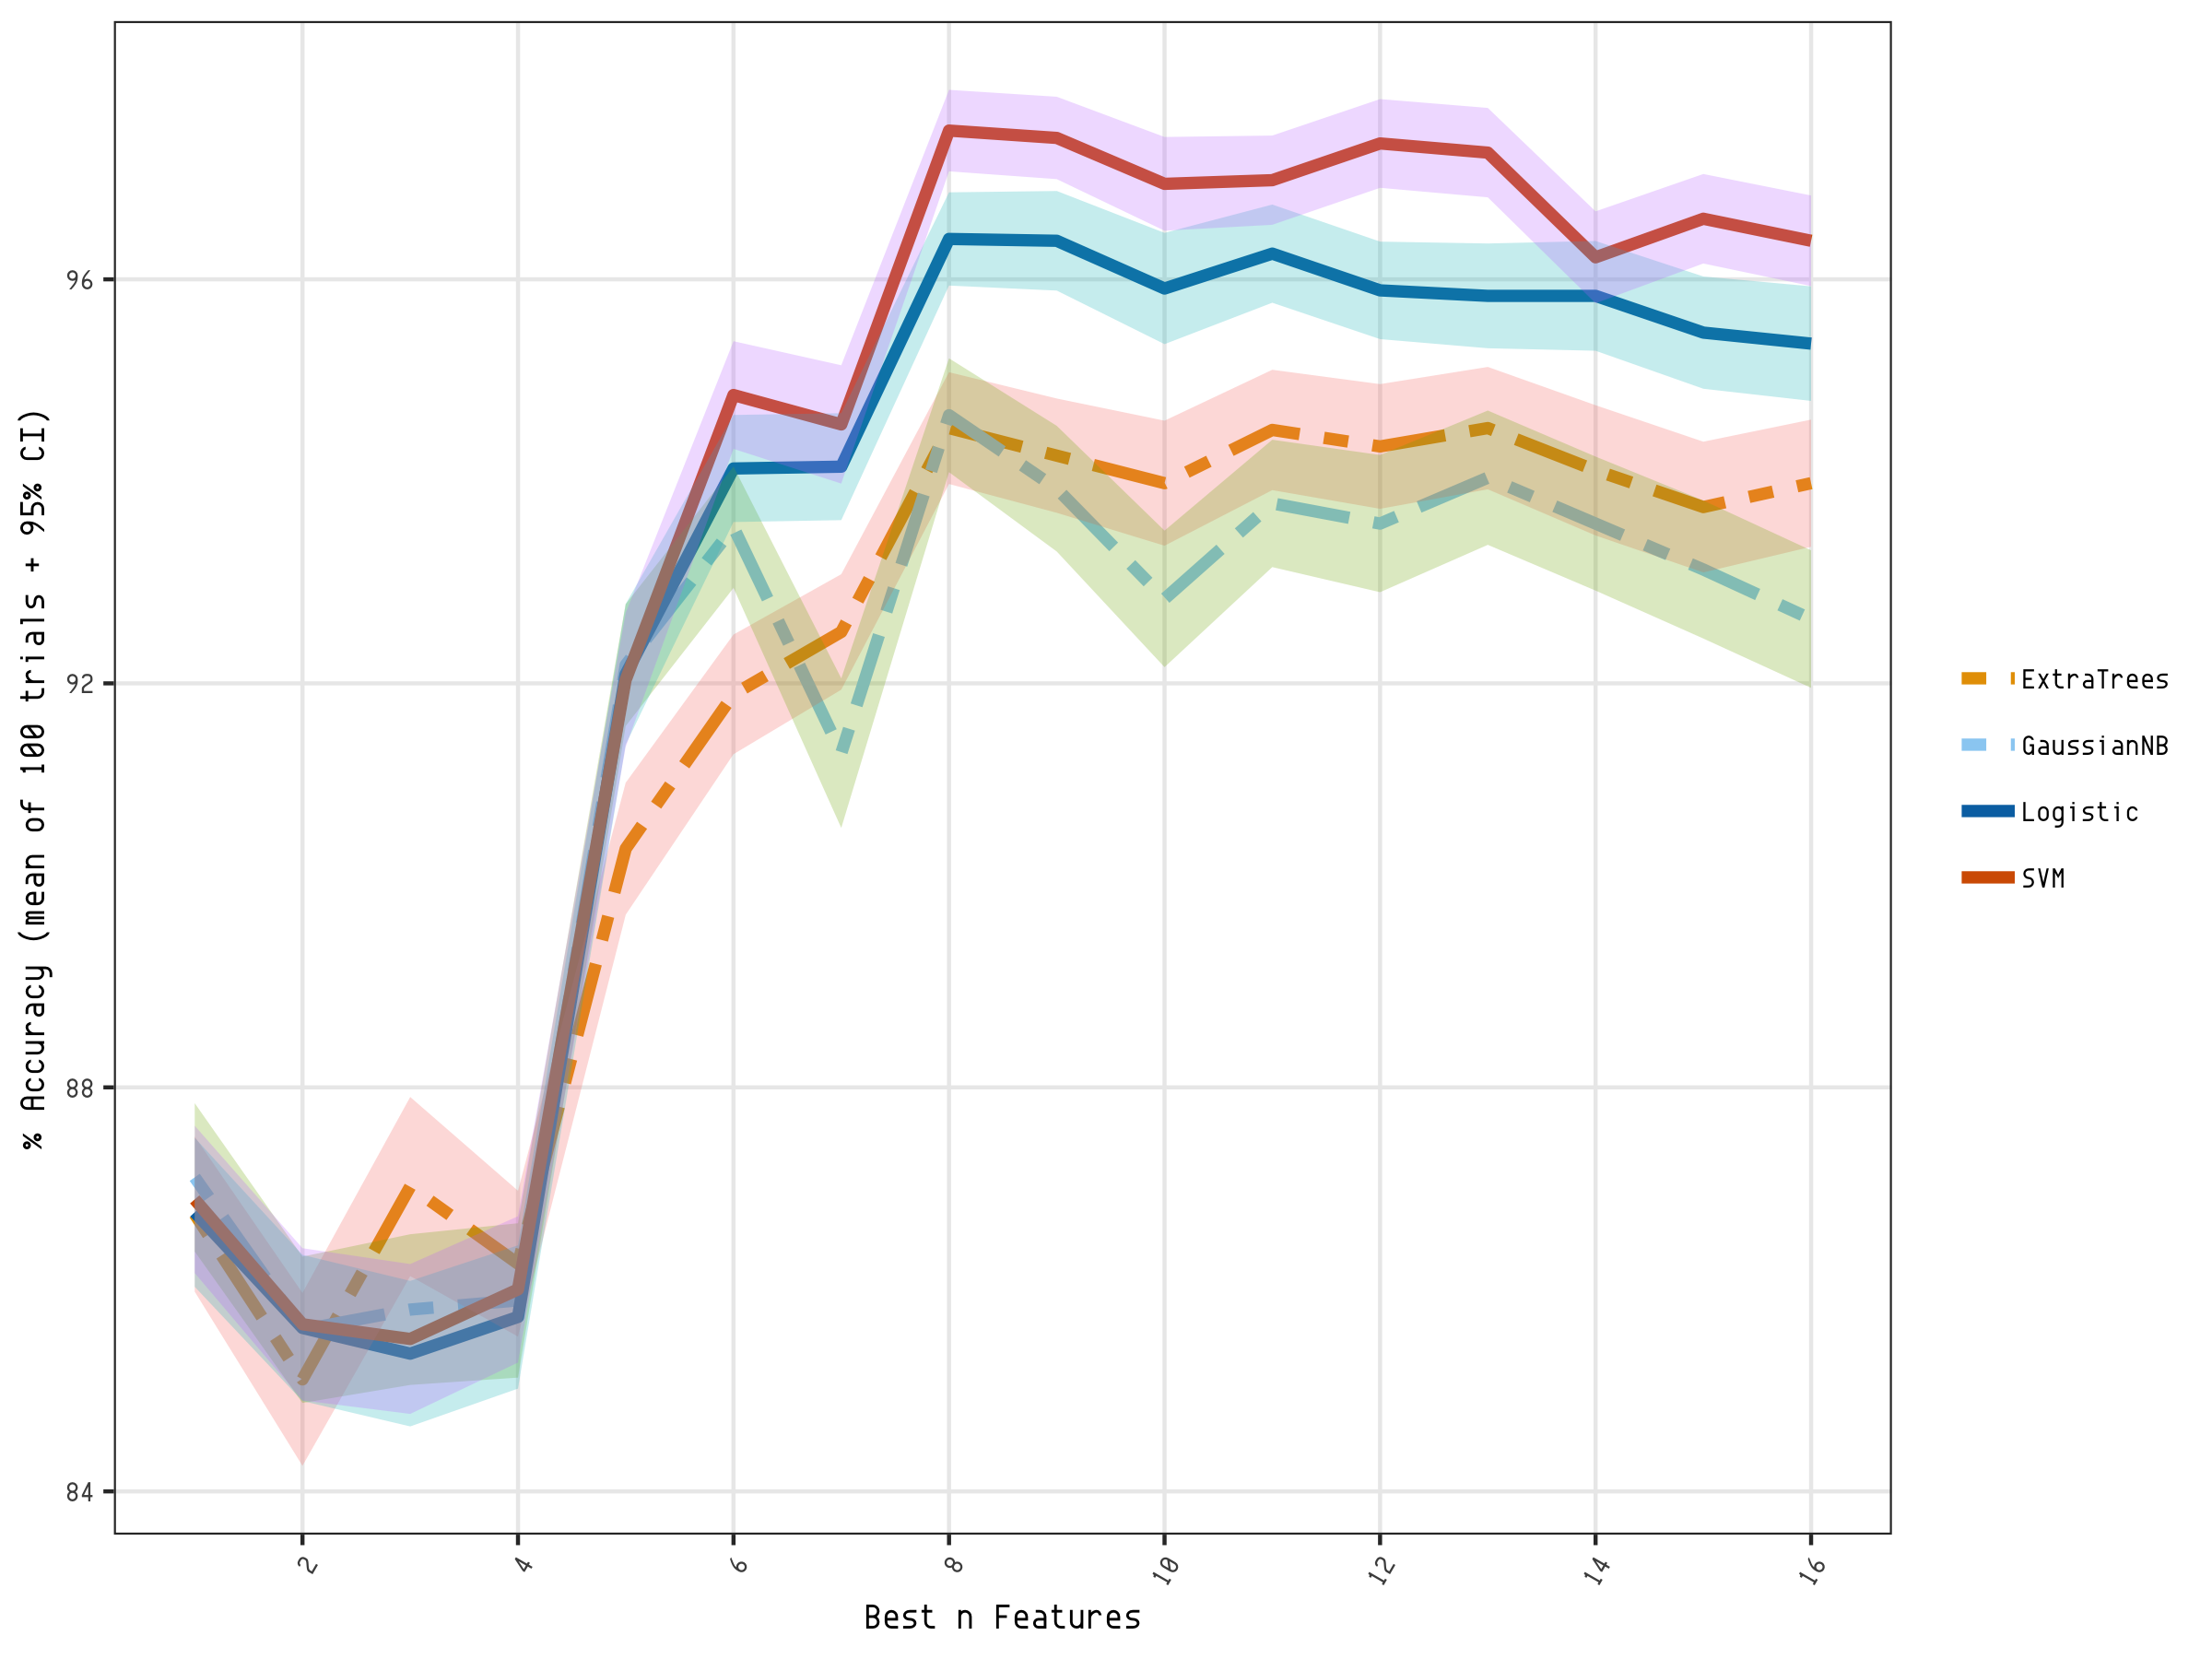

In [266]:
%%R -i x_global -h 6 -w 8 -u in -r 300

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

ggplot(data=x_global, aes(x=Features, y=Score*100, linetype=Classifier)) +
geom_line(aes(color=Classifier), size=1.5) +
# This CI band is not shown in the paper figure, because it's not useful in monochrome
geom_ribbon(
    aes(ymin=Score*100-CI*100, ymax=Score*100+CI*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
labs(x="Best n Features",y="% Accuracy (mean of 100 trials + 95% CI)") +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
scale_x_continuous(breaks = seq(0,16,2)) +
scale_color_manual(values=cbbPaletteDark[c(2:5)])


In [253]:
# For comparison, the first n 'local' features (just based on Silius vs Vergil). As discussed above, the first six
# features do most of the work. This figure is not in the paper.

clfs = [
    ('GaussianNB', lambda: GaussianNB()),
    ('Logistic', lambda: LogisticRegression(penalty='none', solver='lbfgs')),
    ('ExtraTrees', lambda: ExtraTreesClassifier(n_estimators=100,min_samples_split=2)),
    ('SVM', lambda: SVC(gamma='scale', kernel='poly'))
]
x_local = test_clf_by_feats(clfs, puni_all_d, aen_d, f_local, samps=100)

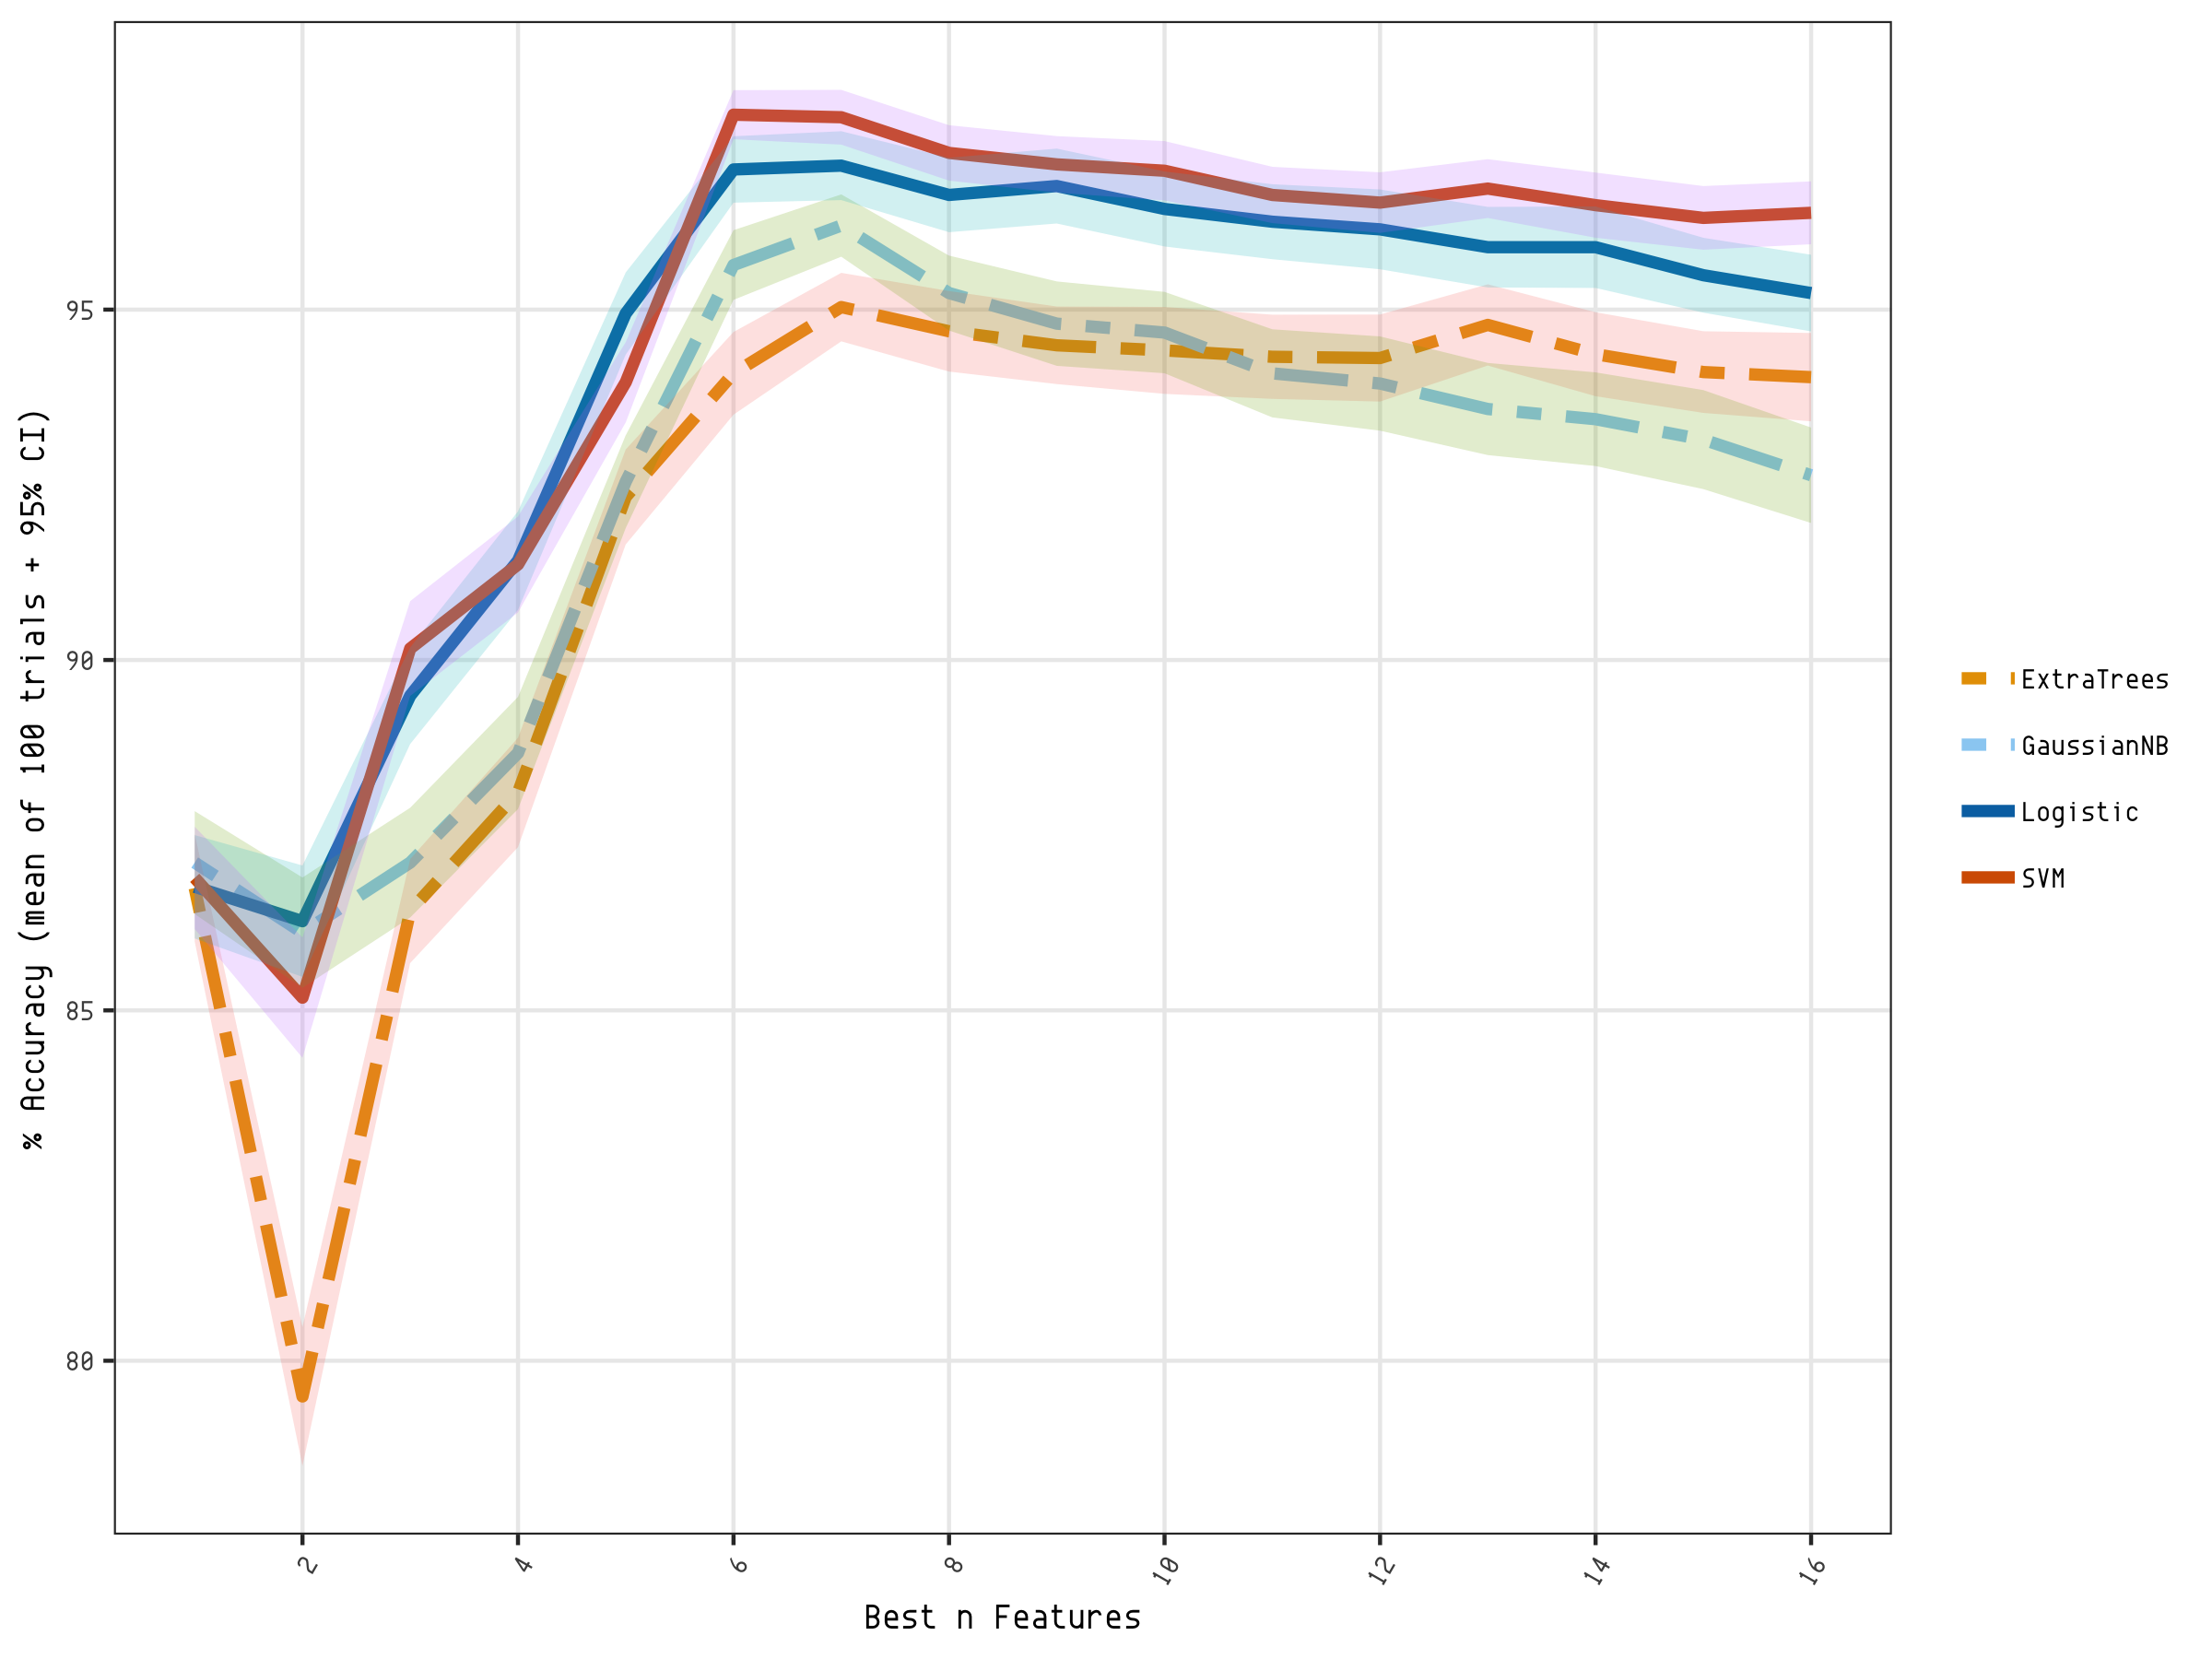

In [251]:
%%R -i x_local -h 6 -w 8 -u in -r 300

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

#parsim_models$Features <- factor(parsim_models$Features)
# This fct_relevel stuff is just nasty ggplot magic to get the features in order from Best 9 ->
ggplot(data=x_local, aes(x=Features, y=Score*100, linetype=Classifier)) +
geom_line(aes(color=Classifier), size=1.5, alpha=1) +
geom_ribbon(
    aes(ymin=Score*100-CI*100, ymax=Score*100+CI*100, fill=Classifier), 
    alpha=0.2, show.legend=FALSE) +
labs(x="Best n Features",y="% Accuracy (mean of 100 trials + 95% CI)") +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
scale_x_continuous(breaks = seq(0,16,2)) +
scale_color_manual(values=cbbPaletteDark[c(2:5)])

In [ ]:
# Table 2: Some highly correlated features in Silius' Punica

In [292]:
# pandas df.corr() - pairwise correlation matrix, default measure is Pearson's r

df = la._chunk_mean(puni_all_d, 81)
corrmat = df.corr()
corrmat

F1S       F2S       F3S       F4S       F1C       F2C       F3C  \
F1S   1.000000 -0.231138 -0.037077  0.060106  0.303108 -0.069837  0.144828   
F2S  -0.231138  1.000000 -0.131901 -0.061804  0.147207  0.462810 -0.268312   
F3S  -0.037077 -0.131901  1.000000 -0.065183  0.012138 -0.150255  0.497612   
F4S   0.060106 -0.061804 -0.065183  1.000000  0.041875  0.070972 -0.031297   
F1C   0.303108  0.147207  0.012138  0.041875  1.000000  0.206814  0.007210   
F2C  -0.069837  0.462810 -0.150255  0.070972  0.206814  1.000000 -0.364081   
F3C   0.144828 -0.268312  0.497612 -0.031297  0.007210 -0.364081  1.000000   
F4C   0.064979  0.162979 -0.346872  0.014419  0.105459  0.200220 -0.444225   
BD   -0.149276  0.094048  0.043617  0.031098  0.083924  0.070396  0.094503   
F2SC -0.062135  0.396756 -0.117206  0.046167  0.221627  0.412966 -0.244158   
F3SC  0.107949 -0.149449  0.432947 -0.134125 -0.000050 -0.325072  0.740922   
F4SC  0.067093  0.160810 -0.384780  0.079743  0.131140  0.207884 -0.382755   
F2WC  0.217616 -0.538805  0.104649 -0.035620 -0.120704 -0.743017  0.288765   
F3WC -0.068829  0.181928 -0.576178  0.064524  0.030128  0.336435 -0.842215   
F4WC -0.023371 -0.058068  0.127315 -0.423478 -0.120127 -0.136222  0.166170   
SYN   0.049863 -0.091699  0.014090  0.106493 -0.026237 -0.048203 -0.085053   

           F4C        BD      F2SC      F3SC      F4SC      F2WC      F3WC  \
F1S   0.064979 -0.149276 -0.062135  0.107949  0.067093  0.217616 -0.068829   
F2S   0.162979  0.094048  0.396756 -0.149449  0.160810 -0.538805  0.181928   
F3S  -0.346872  0.043617 -0.117206  0.432947 -0.384780  0.104649 -0.576178   
F4S   0.014419  0.031098  0.046167 -0.134125  0.079743 -0.035620  0.064524   
F1C   0.105459  0.083924  0.221627 -0.000050  0.131140 -0.120704  0.030128   
F2C   0.200220  0.070396  0.412966 -0.325072  0.207884 -0.743017  0.336435   
F3C  -0.444225  0.094503 -0.244158  0.740922 -0.382755  0.288765 -0.842215   
F4C   1.000000 -0.378409  0.200209 -0.470140  0.856282 -0.184416  0.419604   
BD   -0.378409  1.000000  0.093226  0.110919 -0.360598 -0.014687 -0.100172   
F2SC  0.200209  0.093226  1.000000 -0.285748  0.194956 -0.571422  0.238756   
F3SC -0.470140  0.110919 -0.285748  1.000000 -0.461008  0.233206 -0.778253   
F4SC  0.856282 -0.360598  0.194956 -0.461008  1.000000 -0.167780  0.373782   
F2WC -0.184416 -0.014687 -0.571422  0.233206 -0.167780  1.000000 -0.261469   
F3WC  0.419604 -0.100172  0.238756 -0.778253  0.373782 -0.261469  1.000000   
F4WC -0.151722 -0.272445 -0.069686  0.165448 -0.171944  0.045525 -0.195819   
SYN  -0.042889 -0.198190 -0.057600 -0.154510 -0.086852 -0.055627  0.064547   

          F4WC       SYN  
F1S  -0.023371  0.049863  
F2S  -0.058068 -0.091699  
F3S   0.127315  0.014090  
F4S  -0.423478  0.106493  
F1C  -0.120127 -0.026237  
F2C  -0.136222 -0.048203  
F3C   0.166170 -0.085053  
F4C  -0.151722 -0.042889  
BD   -0.272445 -0.198190  
F2SC -0.069686 -0.057600  
F3SC  0.165448 -0.154510  
F4SC -0.171944 -0.086852  
F2WC  0.045525 -0.055627  
F3WC -0.195819  0.064547  
F4WC  1.000000 -0.134986  
SYN  -0.134986  1.000000

In [286]:
# a little bit of panda magic...

a,b = np.where(np.logical_and(abs(corrmat)>0.5,abs(corrmat)<1.0)) # two arrays of indices
x = [(corrmat.columns[i],corrmat.columns[j]) for i,j in zip(a,b)] # pairwise (feat_i, feat_j) indices
correlated = [((i,j), corrmat[i][j]) for i,j in x] # tuple (feat_i, feat_j), value
correlated

[(('F3S', 'F3WC'), -0.5024013961865836),
 (('F2C', 'F2WC'), -0.7117254327482047),
 (('F3C', 'F3SC'), 0.7872458089769174),
 (('F3C', 'F3WC'), -0.8828243694102488),
 (('F4C', 'F4SC'), 0.8691653291659567),
 (('F2SC', 'F2WC'), -0.5122742854403592),
 (('F3SC', 'F3C'), 0.7872458089769174),
 (('F3SC', 'F3WC'), -0.8684154981067187),
 (('F4SC', 'F4C'), 0.8691653291659567),
 (('F2WC', 'F2C'), -0.7117254327482047),
 (('F2WC', 'F2SC'), -0.5122742854403592),
 (('F3WC', 'F3S'), -0.5024013961865836),
 (('F3WC', 'F3C'), -0.8828243694102488),
 (('F3WC', 'F3SC'), -0.8684154981067187)]

In [304]:
# Each pair appears twice, we just want one of each---take the top half.
# Again, this is the guts of Table 2 in LaTeX.

for (f1, f2), r in correlated[:(len(correlated)//2)+1]:
    print("\\texttt{%s} & \\texttt{%s} & %.3f \\\\" % (f1, f2, r))

\texttt{F3S} & \texttt{F3WC} & -0.502 \\
\texttt{F2C} & \texttt{F2WC} & -0.712 \\
\texttt{F3C} & \texttt{F3SC} & 0.787 \\
\texttt{F3C} & \texttt{F3WC} & -0.883 \\
\texttt{F4C} & \texttt{F4SC} & 0.869 \\
\texttt{F2SC} & \texttt{F2WC} & -0.512 \\
\texttt{F3SC} & \texttt{F3C} & 0.787 \\
\texttt{F3SC} & \texttt{F3WC} & -0.868 \\


In [303]:
# Now we're in the second section of the paper, which is Authorship Attribution Land.

In [300]:
# Table 3: Feature contribution vectors and Mahalanobis distance (M^2)
# when comparing the Additamentum to Silius' Punica and Vergil's Aeneid. 
# For comparison, distance from the centroid of the Aeneid to the Punica.

In [316]:
# First, I want to explain how I determined that 10,000 was a good number of samples
# to take for a randomised distribution to measure the Mahalanobis distance again.
# This is not shown in the paper because it's a little boring.

In [308]:
# For this table, we don't include the Additamentum (it might not be genuine)
# and we start with the lines unshuffled (it's just how I did it, no good reason)

puni_d = la.distribution([l for l in puni if l not in addit])
aen_d = la.distribution(aen)
addit_d = la.distribution(addit)
addit_c = la.centroid(addit)

In [309]:
# The plan is to test sample sizes from 500 to 25000 and measure the M^2 of the Addit.
# from that sample, and also the trace of the co-variance matrix of each distribution. When
# the M^2 distance and the trace start to settle down, the sampled distribution is
# approximating the true distribution, and we'll call it 'enough samples'.

sizes = list(range(0,25001,500))[1:]
res = np.empty(len(sizes), dtype=object)
for idx, s in enumerate(sizes):
    d = maha._create_sampled_dist(puni_d, 81, s, seed=idx)
    cov = np.cov(d.values.T)
    _,m,_ = maha.explain(addit_c, d)
    res[idx] = {'M':m, 'TrCov': cov.trace()}

In [312]:
how_many = pd.DataFrame(list(res))
how_many['L'] = sizes

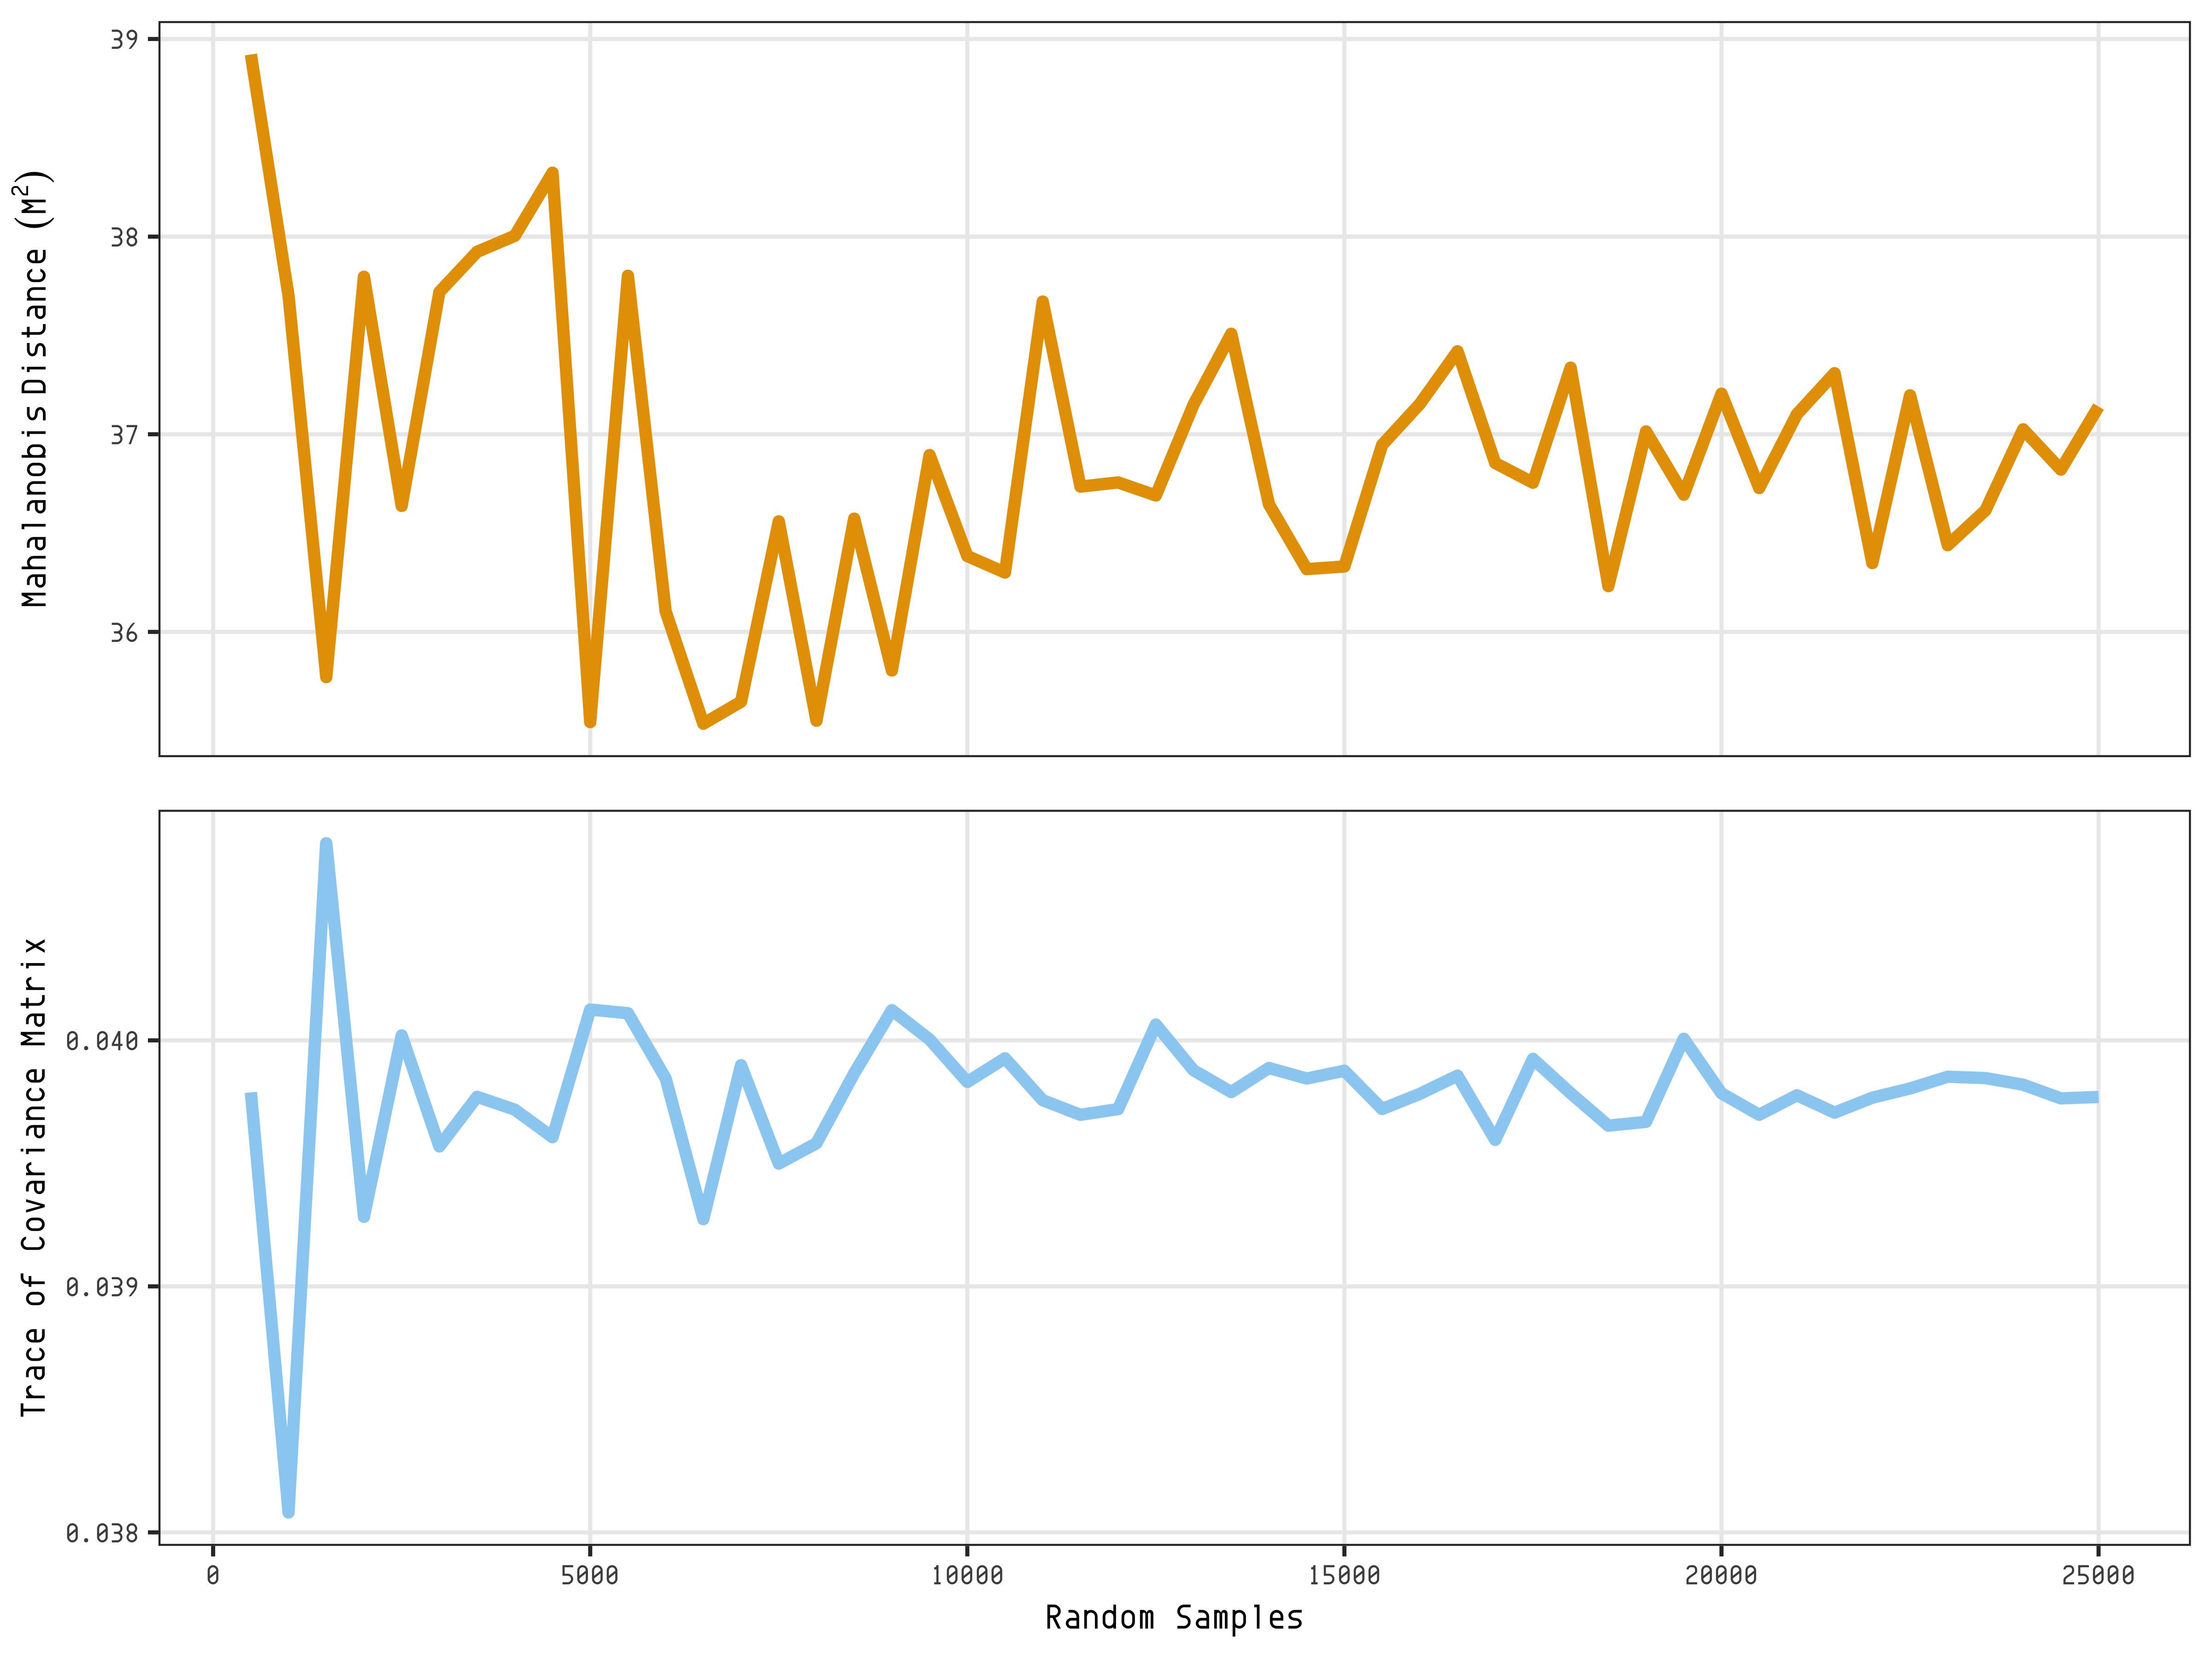

In [336]:
%%R -i how_many -h 6 -w 8 -u in -r 600

# Data Scientists get angry when asked to plot two series with
# different axes on the same graph, so here we bind two plots in 
# the same figure.

p1 <- ggplot(data=how_many, aes(x=L, y=M)) +
geom_line(color="#e79f00", size=1.5) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(plot.title = element_text(margin = margin(b = 50)),
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x=element_blank()) +
labs(y=expression(Mahalanobis~Distance~~(M^2))) +
scale_color_manual(values=cbbPaletteDark[c(2:5)])

p2 <- ggplot(data=s2, aes(x=L, y=TrCov)) +
geom_line(color= "#9ad0f3", size=1.5) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(plot.title = element_text(margin = margin(b = 50))) +
labs(x="Random Samples",y="Trace of Covariance Matrix") +
scale_color_manual(values=cbbPaletteDark[c(2:5)])

grid.newpage()
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))

In [318]:
# So, from about 10,000 it's all fairly sidewise on the covariance trace
# as well as on the M^2 distance, although we still have a little variability there

In [319]:
DISTSZ = 10000
CHUNKSZ = 81

In [325]:
# Now we know how many samples is sensible, we build Table 3.

In [320]:
# This uses the chunk_explain method from my MQDQParser library.
# Consult the docs, but it returns a triple (M^2 dist, p-value, feature_contribution_vector)

# Create the data for the three columns
s1 = maha.chunk_explain(addit_d, puni_d, n=DISTSZ, seed=42)
s1

(36.82277325239188, 0.0013431487736584868, F2WC    12.787810
 F1C      7.428233
 BD       7.055284
 F4SC     2.884053
 F2SC     2.307121
 F3C      2.150830
 F3SC     2.091191
 F3WC     1.093852
 F4S      0.828582
 F4WC     0.459838
 SYN      0.400215
 F3S      0.291279
 F1S      0.146699
 F2S     -0.208142
 F4C     -1.444371
 F2C     -1.449701
 dtype: float64)

In [321]:
s2 = maha.chunk_explain(addit_d, aen_d, n=DISTSZ, seed=42)
s3 = maha.chunk_explain(aen_d, puni_d, chunksz=81, n=DISTSZ, seed=42)

In [324]:
# data massage

d1 = dict(s1[2])
d2 = dict(s2[2])
d3 = dict(s3[2])
dist1, p1 = s1[:2]
dist2, p2 = s2[:2]
dist3, p3 = s3[:2]

In [323]:
# Emit the LaTeX.

for idx, (k, v) in enumerate(d1.items()):
    print("\\texttt{%s} & %.2f & %.2f & %.2f\\\\" % (k,v, d2[k], d3[k]))
print("Raw Distance & %.2f & %.2f & %.2f\\\\" % (dist1, dist2, dist3))
print("p-value & %.4f & %.4f & %.2f \\\\" % (p1, p2, p3))

\texttt{F2WC} & 12.79 & 13.53 & 0.09\\
\texttt{F1C} & 7.43 & 3.48 & 0.21\\
\texttt{BD} & 7.06 & 6.26 & -0.03\\
\texttt{F4SC} & 2.88 & 0.18 & 1.80\\
\texttt{F2SC} & 2.31 & 3.45 & 0.16\\
\texttt{F3C} & 2.15 & 8.55 & 5.17\\
\texttt{F3SC} & 2.09 & 0.35 & 0.35\\
\texttt{F3WC} & 1.09 & 0.00 & 0.82\\
\texttt{F4S} & 0.83 & 0.90 & -0.00\\
\texttt{F4WC} & 0.46 & 1.10 & 0.02\\
\texttt{SYN} & 0.40 & 0.17 & 1.52\\
\texttt{F3S} & 0.29 & 0.04 & 0.05\\
\texttt{F1S} & 0.15 & 1.25 & 4.14\\
\texttt{F2S} & -0.21 & 0.64 & 0.21\\
\texttt{F4C} & -1.44 & 0.04 & -0.62\\
\texttt{F2C} & -1.45 & -0.59 & 2.00\\
Raw Distance & 36.82 & 39.36 & 15.88\\
p-value & 0.0013 & 0.0006 & 0.39 \\


In [ ]:
# Figure 6
# Comparison: The Mahalanobis distance of undisputed lines, taking a rolling window
# of 81-line chunks. The Mahalanobis distance of the Additamentum is shown as a 
# horizontal dotted line.

In [326]:
# walk through the full puni_d, comparing every 81 lines with a shuffled 'normal' dist
CHUNKSZ=81
DISTSZ=10000
res_rdist = []
for cut in np.arange(0,len(puni_d)-CHUNKSZ,27):
    before = puni_d[:cut]
    samp = puni_d[cut:cut+CHUNKSZ]
    after = puni_d[cut+CHUNKSZ:]
    dist = pd.concat([before,after])
    if len(samp) != CHUNKSZ:
        raise RuntimeError("broken!")
    if len(dist) != len(puni_d)-CHUNKSZ:
        raise RuntimeError("broken!")
    m, _, _ = maha.chunk_explain(samp, dist, n=DISTSZ, seed=cut)
    res_rdist.append(m)

In [327]:
# Set up the results - L (line number) against M (M^2 distance for this chunk)

silius_m_var = pd.DataFrame(zip(np.arange(0,len(puni_d)-CHUNKSZ,27), res_rdist))
silius_m_var.columns=['L', 'M']

addit_m_dist = s1[0] # (see above)

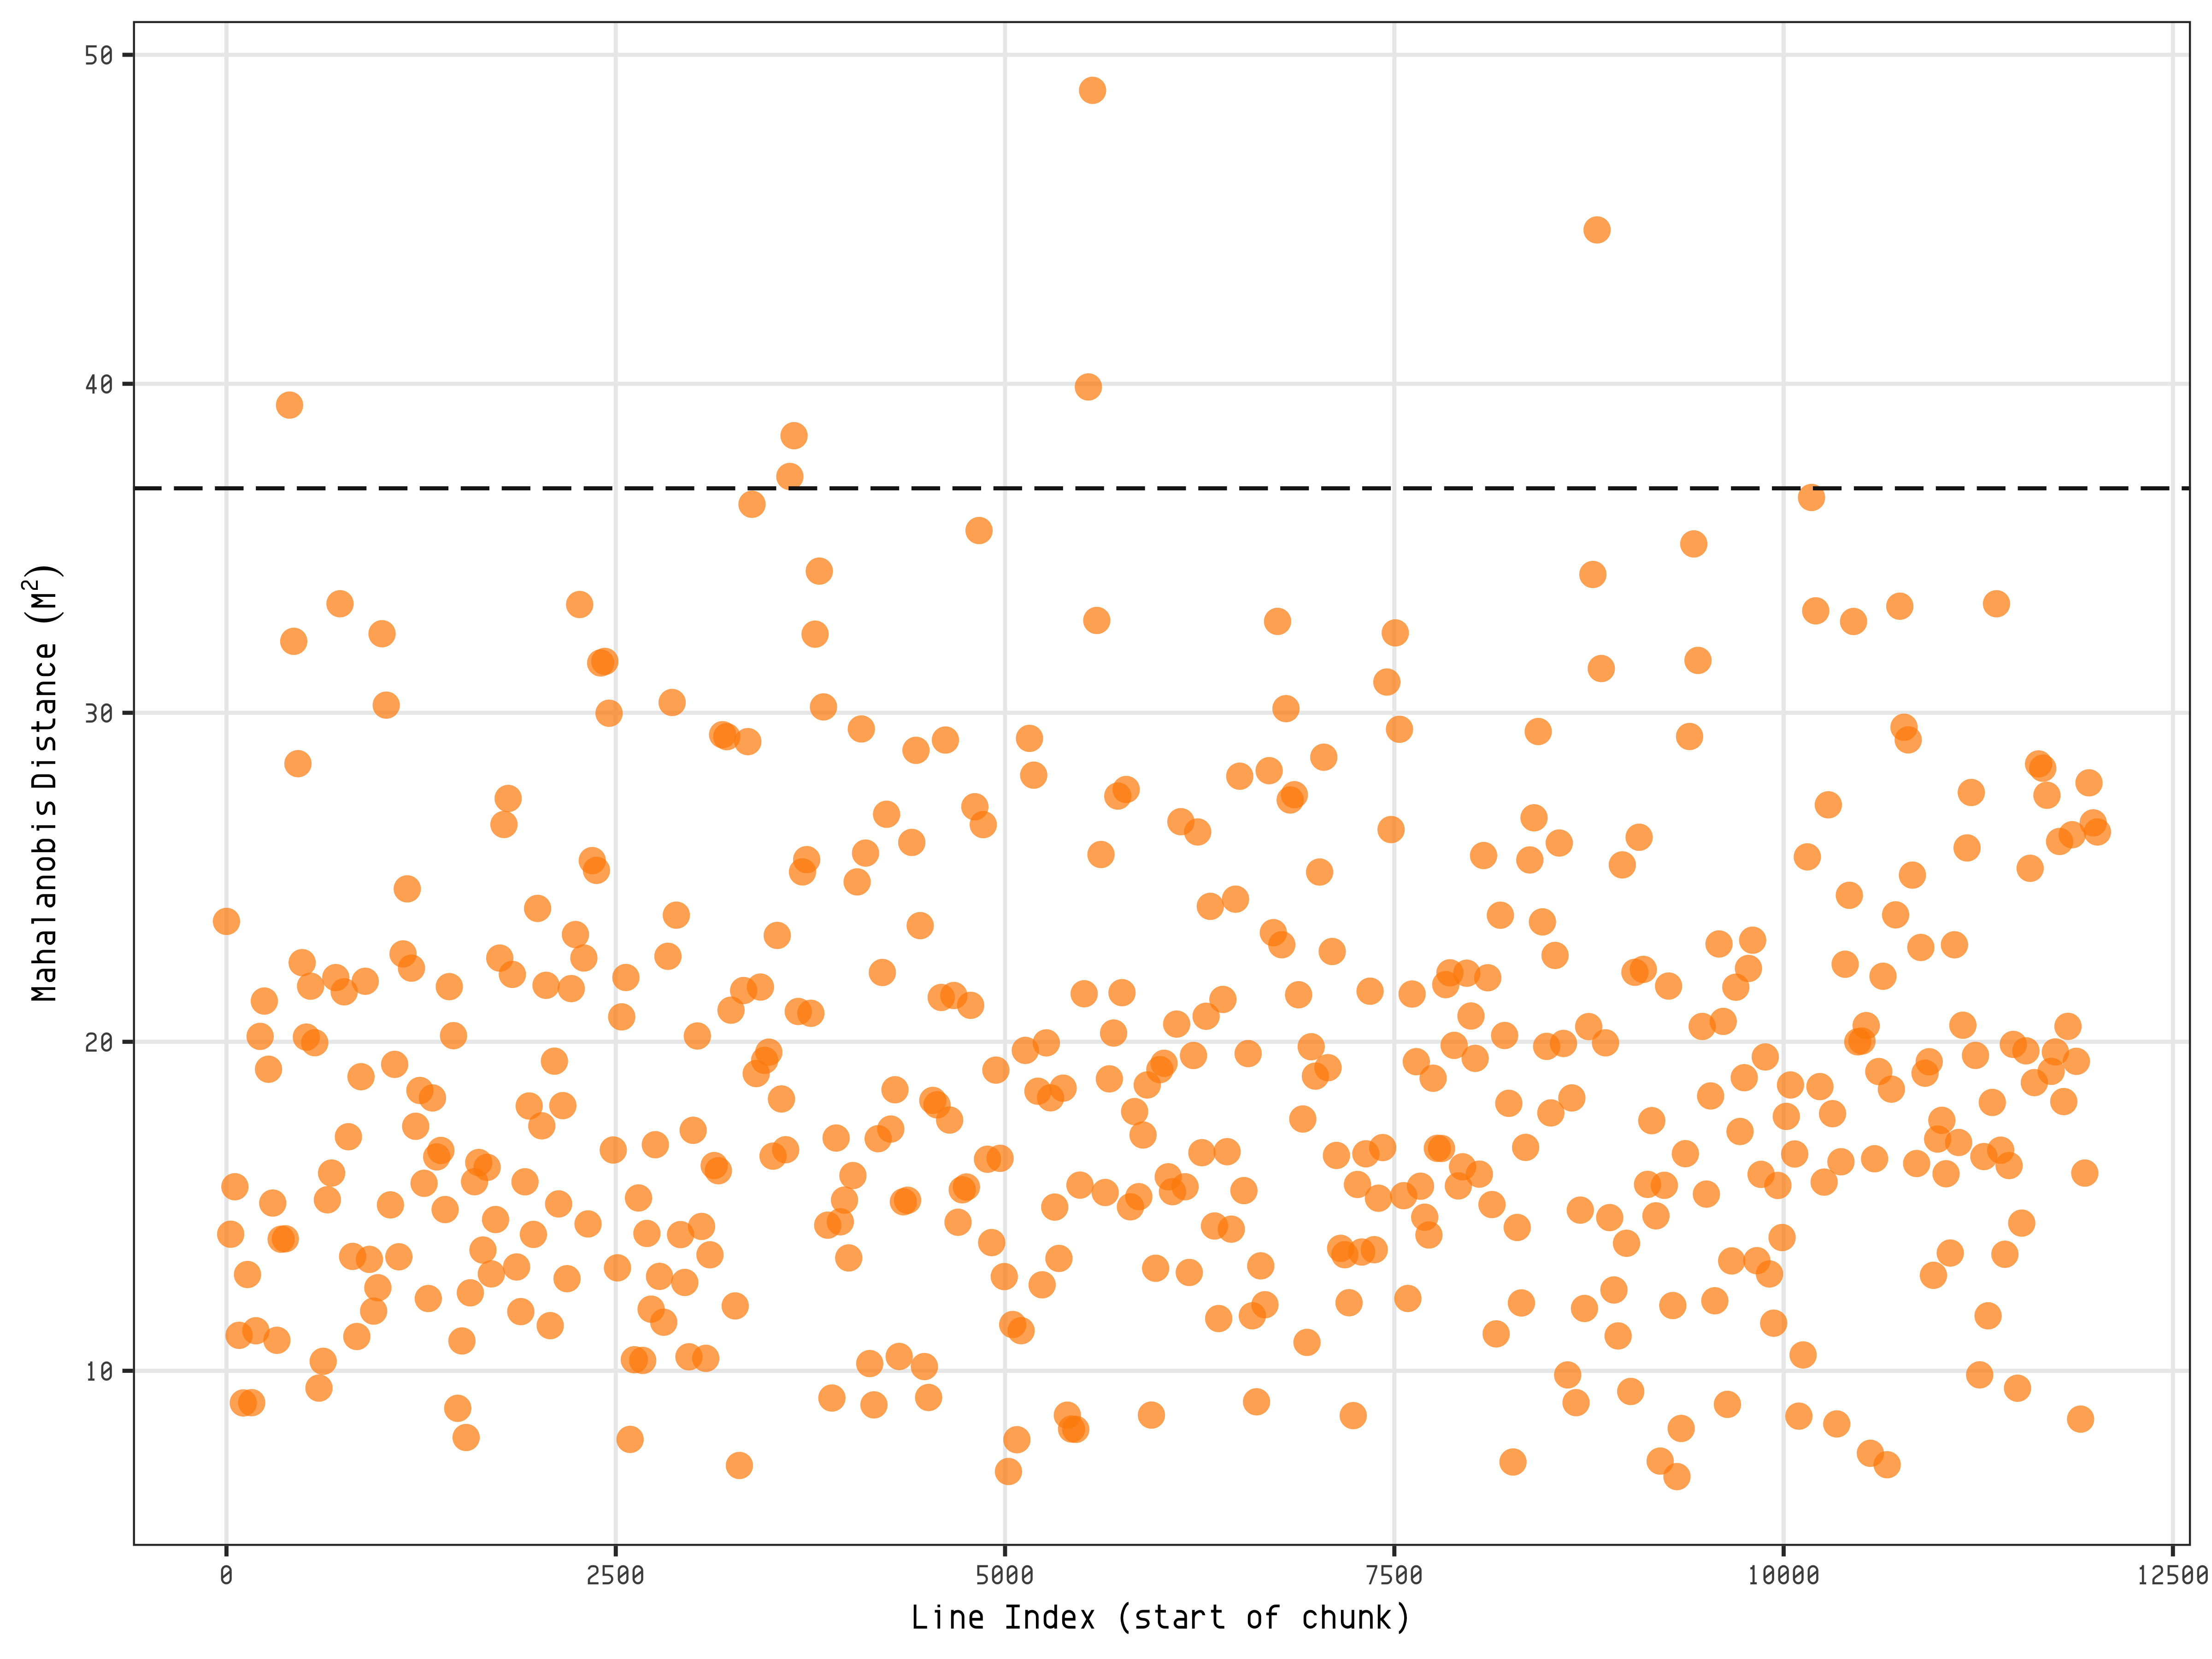

In [337]:
%%R -i silius_m_var,addit_m_dist -h 6 -w 8 -u in -r 600

ggplot(data=silius_m_var,aes(x=L, y=M)) +
geom_point(color='dark orange', size=3, alpha=0.7, shape=16) +
geom_hline(yintercept=addit_m_dist, linetype=5, color=grey(0.1)) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(plot.title = element_text(margin = margin(b = 50))) +
labs(x="Line Index (start of chunk)",y=expression(Mahalanobis~Distance~~(M^2)))

In [ ]:
# Now we're into the Appendix.
# Table 5: An analysis of the six outliers in Silius’ Punica 
# for readers who might like to manually examine them.

In [338]:
# Get a list of the outliers, with their scores

weird_chunks = silius_m_var[silius_m_var['M']>addit_m_dist] # panda magic
weird_chunks = weird_chunks.reset_index()
weird_chunks['L'] = weird_chunks['L'].astype('int64') # cast L to int so chunk method will work
weird_chunks

index     L          M
0     15   405  39.352241
1    134  3618  37.182503
2    135  3645  38.423096
3    205  5535  39.904389
4    206  5562  48.919219
5    326  8802  44.677184

In [339]:
# Standard helper.

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [340]:
# I have to admit, this is just awful. I'm sorry.
# It works, and I won't ever need to re-use it. :(

seed = 42
for trip in chunks(weird_chunks['L'],3):
    print('''
\hline
\\textit{p} & $M^{2}$ & \multicolumn{2}{c||}{Book Ref.} & \\textit{p} & $M^{2}$ & \multicolumn{2}{c||}{Book Ref.} & \\textit{p} & $M^{2}$ & \multicolumn{2}{c|}{Book Ref.} \\\\
\hline
''')

    res = []
    dists = []
    samps = []
    for x in trip:
        before = puni_d[:x]
        samp = puni_d[x:x+CHUNKSZ]
        after = puni_d[x+CHUNKSZ:]
        dist = pd.concat([before,after])
        res.append(maha.chunk_explain(samp,dist,n=DISTSZ, seed=seed))
        seed+=42
        dists.append(dist)
        samps.append(samp)
    items = [r[2].iteritems() for r in res]
    samp_cents = [la._chunk_mean(x,len(x)) for x in samps]
    dist_cents = [la._chunk_mean(dist,len(dist)) for x in dists]
    trip=list(trip)
    mp = [ res[0][1], res[0][0], utils.bookref(puni_na[trip[0]],puni_soup).rstrip() + ("--%d" % (int(puni_na[trip[0]]['name'])+81) ),
           res[1][1], res[1][0], utils.bookref(puni_na[trip[1]],puni_soup).rstrip() + ("--%d" % (int(puni_na[trip[1]]['name'])+81) ),
           res[2][1], res[2][0], utils.bookref(puni_na[trip[2]],puni_soup).rstrip() + ("--%d" % (int(puni_na[trip[2]]['name'])+81) ),
         ]
    print("%.4f & %.2f & \multicolumn{2}{c||}{%s} & %.4f & %.2f & \multicolumn{2}{c||}{%s} & %.4f & %.2f & \multicolumn{2}{c|}{%s} \\\\" % tuple(mp))
    print('''
\hline
Feat & Score & Samp\% & Mean\% & Feat & Score & Samp\% & Mean\% & Feat & Score & Samp\% & Mean\% \\\\
\hline
''')
    for a,b,c in zip(*items):
        a_stuff = [*a,samp_cents[0][a[0]]*100,dist_cents[0][a[0]]*100]
        b_stuff = [*b,samp_cents[1][b[0]]*100,dist_cents[1][b[0]]*100]
        c_stuff = [*c,samp_cents[2][c[0]]*100,dist_cents[2][c[0]]*100]
        print(
            "\\texttt{%.4s} & %.2f & %.2f & %.2f & \\texttt{%.4s} & %.2f & %.2f & %.2f & \\texttt{%.4s} & %.2f & %.2f & %.2f \\\\" % 
            (*a_stuff, *b_stuff, *c_stuff)
        )
print("\\hline")


\hline
\textit{p} & $M^{2}$ & \multicolumn{2}{c||}{Book Ref.} & \textit{p} & $M^{2}$ & \multicolumn{2}{c||}{Book Ref.} & \textit{p} & $M^{2}$ & \multicolumn{2}{c|}{Book Ref.} \\
\hline

0.0007 & 38.92 & \multicolumn{2}{c||}{ 1:406--487} & 0.0014 & 36.66 & \multicolumn{2}{c||}{ 5:676--757} & 0.0008 & 38.43 & \multicolumn{2}{c|}{ 6:25--106} \\

\hline
Feat & Score & Samp\% & Mean\% & Feat & Score & Samp\% & Mean\% & Feat & Score & Samp\% & Mean\% \\
\hline

\texttt{F3WC} & 17.74 & 22.22 & 12.16 & \texttt{F2S} & 12.48 & 77.78 & 56.19 & \texttt{F2SC} & 17.43 & 85.19 & 62.64 \\
\texttt{F1S} & 5.69 & 64.20 & 50.66 & \texttt{F3WC} & 8.58 & 22.22 & 12.16 & \texttt{F3WC} & 14.41 & 23.46 & 12.16 \\
\texttt{F2C} & 4.64 & 72.84 & 78.34 & \texttt{F4S} & 7.97 & 59.26 & 72.66 & \texttt{F2S} & 10.02 & 75.31 & 56.19 \\
\texttt{F2WC} & 3.51 & 8.64 & 11.60 & \texttt{F2SC} & 4.09 & 77.78 & 62.64 & \texttt{F4C} & 3.12 & 67.90 & 60.67 \\
\texttt{F3SC} & 3.37 & 71.60 & 81.88 & \texttt{F4C} & 3.02 & 66.67 & 

In [ ]:
# And that's it!